# Associations with *Exactly*

## ⭐ Imports

In [1]:
# import association_measures as am
import matplotlib as mpl
# import more_itertools as more_it
from am_notebooks import *

from source.utils import colors
from source.utils.associate import ALPHA, AM_DF_DIR, TOP_AM_DIR
# from source.utils.dataframes import transform_counts
from source.utils.general import confirm_dir
from source.utils.LexicalCategories import SPECIAL_ADV as special, EXACTLY_RELEVANT_ADJ as ERA
# from source.utils.LexicalCategories import TOP_NEG_ADV as manual_neg
# from source.utils.LexicalCategories import TOP_POS_ADV as manual_pos
K = 25
NOTEBOOK = 'notebooks/all_exactly_am.ipynb'
TOP_BLIND_ADJ_PATH=TOP_AM_DIR/f'top{K}_exactly_blind_adj.txt'
TOP_POLAR_ADJ_PATH=TOP_AM_DIR/f'top{K}_exactly_polar_adj.txt'

SHOW_FIGS = False
COLUMN_LIST = INVESTIGATE_COLUMN_LIST
# COLUMN_LIST = ['l2', 'polarity', 'direction', 'space',
#                'pos_sample', 'dataset', 'adj', 'adj_total',
#                'dP1', 'dP1m', 'LRC', 'LRCm',
#                'P1', 'P1m', 'G2',
#                'f1', 'f2', 'N',
#                'f', 'exp_f', 'unexp_f',
#                'f_sqrt', 'f2_sqrt', 'unexp_f_sqrt',
#                'N_sqrt',
#                'unexp_r', 'unexp_r_m',
#                'unexp_f_sqrt_m', 'f_sqrt_m', 'f2_sqrt_m',
#                'polar_l2', 'space_l2']

print('Date run:', timestamp_today())
# print(pd.Series(COLUMN_LIST, name='column selection', dtype='string'))
plt = mpl.pyplot

# plt.style.use('Solarize_Light2')
# plt.style.use('seaborn-v0_8-deep')
# plt.style.use('seaborn-v0_8-darkgrid')
# plt.style.use('dark_background')
# plt.style.use('seaborn-v0_8-dark-palette')
# plt.style.use('seaborn-v0_8-dark')
# plt.style.use('_mpl-gallery-nogrid')
# plt.style.use('bmh')
# plt.style.use('seaborn-v0_8-pastel')
# plt.style.use('seaborn-v0_8-ticks')
plt.style.use('seaborn-v0_8-paper')
# plt.style.use('seaborn-v0_8-notebook')
# plt.style.use('seaborn-v0_8-whitegrid')
# plt.style.use('seaborn-v0_8-bright')

plt.rcParams['font.family'] = 'serif'

pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 12)
pd.set_option('display.max_rows', 80)
pd.set_option('display.width', 90)
pd.set_option("display.precision", 2)
# pd.set_option("styler.format.precision", 6)
pd.set_option("styler.format.thousands", ",")
pd.set_option("styler.sparse.columns", True)
pd.set_option("styler.sparse.index", True)
pd.set_option("display.float_format", '{:,.2f}'.format)

Date run: 2025-03-02


|                   | *exactly* | <u>not</u> *exactly* |     margin |
|-------------------|----------:|---------------------:|-----------:|
| subset            |     1,031 |            1,679,602 |  1,680,633 |
| <u>not</u> subset |    55,078 |           70,225,662 | 70,280,740 |
| **margin**        |    56,109 |           71,905,264 | 71,961,373 |

### Function Definitions

In [2]:
# ! Definition must remain in notebook in order to access `NOTEBOOK` contstant
def get_call_comment(_call):
    call_info = [str(x) for x in [NOTEBOOK, _call.lineno, _call.code_context, _call.index, _call.function]]
    return textwrap.indent('\n'.join([f"timestamp: {timestamp_now()}", "origin: " + '; '.join(call_info)]),'% ')
print(get_call_comment(ist()[0]))

% timestamp: 2025-03-02_2334
% origin: notebooks/all_exactly_am.ipynb; 5; ['print(get_call_comment(ist()[0]))\n']; 0; <module>


In [3]:
def get_sensitive_bigram_totals(sig_df):
    
    signif_counts = (sig_df.loc[sig_df.polarity == 'neg', :]
                     .groupby(['direction', ], observed=False)
                     .value_counts(['dataset', 'pos_sample']).to_frame('Negative "exactly" bigrams')
                     .unstack(['dataset', 'pos_sample'])
                     )  # .apply(lambda x: x/x.sum(), axis=1).apply(lambda x: x/x.sum(), axis=0)
    signif_counts = (sig_df  # .loc[sig_df.polarity=='neg', :]
                     .groupby(['polarity', 'dataset', 'pos_sample'], observed=True)
                     .value_counts(['direction', ]).to_frame('Polar Sensitive "exactly" bigrams')
                     .unstack(['dataset', 'pos_sample'])
                     )  # .apply(lambda x: x/x.sum(), axis=0)
    signif_counts['total'] = signif_counts.sum(axis=1)

    return signif_counts.assign(ratio=signif_counts[['total']].apply(
        lambda x: x/(x.sum()/2)))


def display_sensitive_totals(df, latex=False):
    sig_totals = get_sensitive_bigram_totals(df)
    caption=(
                         f'Polar sensitivities across {len(df):,} evaluations<br/>'
                         f'* <i>{df.l2.nunique():,} unique "exactly" bigrams</i><br/>'
                         f'* <i>minimum bigram subtotal in any space = {df.f2.min()}</i>'
                         '<br/>'
                         f'* <i>minimum bigram subtotal in <u>superset</u> = {df.filter(like="ALL+sup", axis=0).f2.min()}</i>'
                         '<br/>'
                         f'* <i>minimum</i> <u>mean</u> <i>bigram subtotal = {df.f2_m.min():.0f}</i>'
                     )
    sty = format_zeros(
        sig_totals.style
        .background_gradient(subset=sig_totals.columns.to_list()[:4],
                             axis=None, cmap='GnBu')
        .background_gradient(subset=['total'], cmap='Blues', axis=0)
        .background_gradient(subset=['ratio'], cmap='Greens', axis=0))
    if latex: 
        caption = caption.replace('<br/>','\\\\').replace('• ','')
        sty = sty.format(na_rep='',thousands=',', escape='latex')
        label=f'signif-counts-{str(df.f2.min()).zfill(2)}f2-'+f'{df.f2_m.min():.0f}'.zfill(2) +'f2m'
        save_latex_table(sty, caption = caption, label=label, verbose=True,
                         latex_subdir='exactly/signif_counts',latex_stem=f'exactly_{label}',
                         call_comment=get_call_comment(ist()[0]),
                         )
        return sty
    return (
        set_my_style(sty, caption_align='left', 
                     caption=caption)
    )



def plot_quantiles(df,
                   base: str = r'f2?',
                   log_y: bool = True,
                   per_mill: bool = True,
                   sqrt: bool = False,
                   include_mean: bool = True,
                   plot_kind: str = 'bar',
                   columns: list | tuple | pd.Index = None):
    '''
    Note: if columns are passed, then neither `per_mill` nor `sqrt` will have any effect on the data selection. 
    Use `per_mill` to modify the y-axis label
    '''
    columns = columns or df.filter(
        regex=((r'tpm_' if per_mill else r'^')
               + base
               + ('_sqrt' if sqrt else '')
               + (r'_?m?$' if include_mean else r'$'))
    ).columns
    inc = 10 if plot_kind == 'line' else 50
    quant_series = df.copy().filter(columns).quantile(
        [x/1000 for x in range(inc, 1000+inc, inc)])

    quant_series.plot(
        kind=plot_kind, figsize=(7, 4),
        cmap='little_mermaid', grid='y',
        title=(f'Frequency Quantiles\nSpaces included: {repr(set(df.space))}\n'
               f'{df.l2.nunique():,} unique {"bigrams" if any(df.l2.str.contains("_")) else "adjectives"}'),
        xlabel='Quantile', rot=0,
        ylabel=(
            ('√ of' if sqrt else '')
            + ' bigram tokens'
            + (' per million' if per_mill else '')
            + (' (log)' if log_y else '')),
        logy=log_y)
    if len(quant_series) < 25:
        return quant_series.style.background_gradient(cmap='magma', axis=None, low=0.3)
def designate_bins(df, column, n_quantiles=10, verbose:bool=False):
    
    
    def _str_format_numbers(number_series:pd.Series,
                        data_dtype):
        is_integer = (data_dtype.is_signed_integer or data_dtype.is_unsigned_integer)
        return f'{number_series.iloc[1]:,.0f}' if is_integer else f'{number_series.iloc[1]:,.3f}'
    
    """
    Assign quantile bins to a DataFrame column with clear labeling.

    Args:
        df (pd.DataFrame): Input DataFrame
        column (str): Column to bin
        n_quantiles (int, optional): Number of quantile bins. Defaults to 10.

    Returns:
        pd.DataFrame: DataFrame with added quantile columns
    """
    # Compute quantiles, ensuring unique values
    quantile_steps = [x/n_quantiles for x in range(n_quantiles + 1)]
    data_series = df[[column]].convert_dtypes().squeeze()
    data_dtype = data_series.dtype
    bins = data_series.quantile(quantile_steps
                                ).round(5).drop_duplicates(keep='last').astype(data_dtype)
    b_vals = [*bins.iloc[:-1], round(bins.iloc[-1]*1.00001, 5)]
    # if verbose: 
    #     print(bins.to_frame('quantile values').to_markdown(floatfmt=',.4f', intfmt=','), end='\n\n')
    # Ensure 0 is the first bin if not already present
    if bins.iloc[0] == 0: 
        b_vals = [-0.00001, *b_vals] #HACK to deal with first quantile ceiling being 0
        b_labels = bins.index.to_list()
    # elif bins.index[0] != 0:
    else:
        b_vals = [0, *b_vals] 
        b_labels = bins.index.to_list()
        # b_vals = bins.to_list()
        # b_labels = bins.index[:-1].to_list()

    # Create quantile categories
    df[f'{column}_quantile'] = pd.cut(data_series, bins=b_vals, duplicates='drop',
                                      labels=b_labels, include_lowest=True, 
                                      ).astype('float').fillna(b_labels[0])
    df[f'{column}_quantile_ceiling'] = df[f'{column}_quantile'].map(bins).astype('float').fillna(b_vals[0])
    
    # Create informative quantile description
    df[f'{column}_quantile_info'] = (
        df[[f'{column}_quantile', f'{column}_quantile_ceiling']]
        .apply(
            lambda r: 
                f'{r.iloc[0]}:->{_str_format_numbers(r, data_dtype)}', axis=1)
        #// .str.replace(r'(>[\d,]+)\.0+$', r'\1', regex=True)
    )

    # Optional: Print quantile distribution
    if verbose:
        quantile_counts = (
            df.filter(like=f'{column}_quantile')
            .value_counts()
            .sort_index()
            .to_frame()
            .reset_index()
        )
        print(f"\n+ `{column}` Quantile Distribution\n")
        print(' ', quantile_counts.to_markdown(floatfmt=',.'+str(1 if data_dtype.is_signed_integer else (4 if column.startswith('tpm') else 2))+'f', intfmt=',', index=False).replace('\n','\n  '))

    return df



In [4]:

# designate_bins(all_exactly_bigrams, 'f')
# designate_bins(pd.DataFrame(colors.gen_random_array(0, 99, nvecs=300, nvals=2)), 0)
def flag_rows(string_series: pd.Series,
              set_1: set, set_2: set,
              in_both: bool = True,
              members: bool = False,
              pre_1: str = r'Box', 
              pre_2:str = r'ominus',
            #   pre_2: str = '²'
              ):
    print(f'Prefix 1: {pre_1}', 
          f'Prefix 2: {pre_2}', sep = '\n')
    str_series = string_series.copy()
    if members:
        str_series = str_series.apply(lambda a: (
            pre_1 if a in set_1 else pre_2) + ' ' + a)
    if in_both:
        str_series = str_series.apply(lambda a: r'cap ' + (re.sub(f'{pre_1}|{pre_2}', '', a))
                                      if a.endswith(tuple(set_1.intersection(set_2)))
                                      else a)

    return str_series.str.replace(r' {2,}', ' ', regex=True)

In [5]:
exactly_subset_f = pd.DataFrame({
    'subset~exactly':
        {'l1': 'subset',
         'l2': 'exactly',
         'f': 1031,
         'f1': 1680633,
         'f2': 56109,
         'N': 71961373
         }
}).T
nb_display(exactly_subset_f)

exactly_subset_f = exactly_subset_f.join(
    am_fq.observed_frequencies(exactly_subset_f).join(
        am_fq.expected_frequencies(exactly_subset_f)).astype('float'))

exactly_subset_f = adjust_am_names(
    exactly_subset_f.assign(
        unexp_f=exactly_subset_f.f - exactly_subset_f.E11
    ).join(
        am_ms.score(exactly_subset_f, correct=None, measures=[
            'conservative_log_ratio']
        ).filter(like='log')
    ).assign(dP1=deltaP(exactly_subset_f, given=2),
             dP2=deltaP(exactly_subset_f, given=1),
             P1=exactly_subset_f.f/exactly_subset_f.f2,
             P2=exactly_subset_f.f/exactly_subset_f.f1,
             ).filter(regex=r'E11|log|([unexp_]*[f]\d?)|P\d')
)
nb_display(format_zeros(format_negatives(exactly_subset_f.style)))

## Top Level Polar Environment ~ *Exactly* Associations 

_regardless of adjective argument_

Original source files:

```log
+ NEQ+sup
  "RBdirect/adv/extra/polarized-adv_NEQ-direct_min1x_extra.parq"

+ ALL+sup
  "RBdirect/adv/extra/polarized-adv_ALL-direct_min1x_extra.parq"

+ ALL+mir
  "mirror/adv/extra/polarized-adv_ALL-mirror_min1x_extra.parq"

+ NEQ+mir
  "mirror/adv/extra/polarized-adv_NEQ-mirror_min1x_extra.parq"
```

In [6]:
all_exactly_csv = TOP_AM_DIR / 'exactly' / 'combined_env~exactly_AM.csv'
confirm_dir(all_exactly_csv.parent)
if all_exactly_csv.is_file():
    all_exactly = pd.read_csv(
        all_exactly_csv, index_col='space_key').convert_dtypes()
    print(
        f'Loaded processed "exactly" AM values from\n> "{all_exactly_csv.relative_to(SANPI_HOME)}"')
else:
    init_exactly_csv = all_exactly_csv.with_suffix('.init.csv')
    if init_exactly_csv.is_file():
        exactly_loaded = pd.read_csv(
            init_exactly_csv, index_col='space_key').convert_dtypes()
        print(
            f'Loaded initial compilation of "exactly" AM values from\n> "{init_exactly_csv.relative_to(SANPI_HOME)}"')

    else:
        exactly_loaded = load_all_relevant_ams(
            {'exactly', }, label='exactly', f_min=10)  #! NEQ mirror POS~exactly f=49. Using a freq floor >49 will fail to collect this data
        exactly_loaded.to_csv(init_exactly_csv)
    all_exactly = update_amdf(exactly_loaded.filter(COLUMN_LIST))
    all_exactly.to_csv(all_exactly_csv)
# set_my_style(all_exactly.T.style, index_font='', index_size=8, index_weight='bold')
# set_my_style(all_exactly.style, index_font='', index_size=8.5)
all_exactly

Loaded processed "exactly" AM values from
> "results/top_AM/exactly/combined_env~exactly_AM.csv"


l2 polarity    space pos_sample dataset   LRC  ...  \
space_key                                                                ...   
ALL+sup:NEG~exactly  exactly      neg  ALL+sup        ALL   super  6.19  ...   
ALL+mir:NEG~exactly  exactly      neg  ALL+mir        ALL  mirror  3.61  ...   
NEQ+sup:NEG~exactly  exactly      neg  NEQ+sup        NEQ   super  5.97  ...   
NEQ+mir:NEG~exactly  exactly      neg  NEQ+mir        NEQ  mirror  3.09  ...   
NEQ+mir:POS~exactly  exactly      pos  NEQ+mir        NEQ  mirror -3.09  ...   
NEQ+sup:POS~exactly  exactly      pos  NEQ+sup        NEQ   super -5.97  ...   
ALL+mir:POS~exactly  exactly      pos  ALL+mir        ALL  mirror -3.61  ...   
ALL+sup:POS~exactly  exactly      pos  ALL+sup        ALL   super -6.19  ...   

                     tpm_f_sqrt_m  tpm_f1_sqrt_m  tpm_f2_sqrt_m  tpm_exp_f_sqrt_m  \
space_key                                                                           
ALL+sup:NEG~exactly         41.77         510.21          43.69             25.62   
ALL+mir:NEG~exactly         41.77         510.21          43.69             25.62   
NEQ+sup:NEG~exactly         41.77         510.21          43.69             25.62   
NEQ+mir:NEG~exactly         41.77         510.21          43.69             25.62   
NEQ+mir:POS~exactly         10.76         825.25          43.69             34.03   
NEQ+sup:POS~exactly         10.76         825.25          43.69             34.03   
ALL+mir:POS~exactly         10.76         825.25          43.69             34.03   
ALL+sup:POS~exactly         10.76         825.25          43.69             34.03   

                     tpm_unexp_f_sqrt_m  unexp_f_sqrt_m  
space_key                                                
ALL+sup:NEG~exactly               16.15           60.70  
ALL+mir:NEG~exactly               16.15           60.70  
NEQ+sup:NEG~exactly               16.15           60.70  
NEQ+mir:NEG~exactly               16.15           60.70  
NEQ+mir:POS~exactly              -23.27          -68.52  
NEQ+sup:POS~exactly              -23.27          -68.52  
ALL+mir:POS~exactly              -23.27          -68.52  
ALL+sup:POS~exactly              -23.27          -68.52  

[8 rows x 63 columns]

In [7]:
exactly_df = all_exactly.reset_index().set_index(
    ['dataset', 'pos_sample', 'polarity']).convert_dtypes()
exactly_str_info = exactly_df.select_dtypes(include='string')
exactly_df.drop(columns=exactly_df.columns[exactly_df.columns.str.endswith('m')],
                inplace=True)
exactly_df = exactly_df.select_dtypes(
    include='number').sort_values(['N', 'f'], ascending=False)
exactly_df.columns.set_names(names='metric', inplace=True)
# set_my_style(exactly_df.style, index_font='iosevka fixed')
# ')
v_ex_df = exactly_df.copy()
v_ex_df.index.set_names(names=['space', ''], level=[0, 1], inplace=True)
# v_ex_df
# set_my_style(style_neg_vals(v_ex_df).highlight_max(props='background-color:lavender; color:black'))

In [8]:
_col_display_order = ['Set','Sample',  'Polar']

In [9]:
# columns = ['f', 'f2', 'unexp_f',
#            'unexp_r', 'LRC', 'dP1']

_for_sty = exactly_df.filter(
    ['dP1', 'dP2', 'P1',  'P2', 'f', 'f1', 'f2']).reset_index()
_for_sty = (_for_sty
            .rename(
                columns={'pos_sample': 'Sample',
                         'dataset': 'Set',
                         'polarity': 'Polar'})
            .set_index(_col_display_order)
            .sort_index())

In [10]:

save_latex_table(
    format_negatives(
        _for_sty.style.background_gradient(
            'anastasia', subset=['dP1', 'dP2'], vmin=-1, vmax=1)
        .background_gradient('anastasia', subset=['P1', 'P2'], vmin=0, vmax=1)
        .background_gradient('RdPu', subset='f')
        .background_gradient('RdPu', subset=['f1', 'f2'], axis=None)
    ),
    call_comment = get_call_comment(ist()[0]),
    latex_subdir='exactly', verbose=True, caption='Asymmetric AMs for <i>Exactly</i>',
    latex_stem="env-exactly_forward-vs-backward-asymmetric")

Caption: Asymmetric AMs for <i>Exactly</i>


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-exactly_forward-vs-backward-asymmetric.2025-03-02.tex



PosixPath('/share/compling/projects/arh234/OverleafDissertex/assets/tables/exactly/env-exactly_forward-vs-backward-asymmetric.2025-03-02.tex')

In [11]:
#! LaTeX -- but not used
# sty = color_compiled_adv(
#         exactly_df.reset_index(), 'exactly',
#         index_cols=['Polar', 'Set', 'Sample'], 
#         save_table=True
#         )

#HACK This seems like a #BUG but it claims to not match the length of the index if relabeling is applied after columns are hidden
# > so do it beforehand
# sty = rename_cols_for_latex(sty)
# sty = sty.hide(subset=sty.columns[4:].to_list(), 
#          axis='columns')
# save_latex_table(sty, label='pol-exactly',
#                  caption=r'Polar Env $\sim$ \textit{exactly} \underline{AM} Across All Comparison Spaces',
#                  latex_subdir='exactly', verbose=True,
                    # call_comment=get_call_comment(ist()[0]),
#                  latex_stem=snake_to_camel('_'.join(sty.index.names))+'-Env~Exactly_AM-AcrossSpaces')

In [12]:
#! LaTeX --- maybe used (frequency columns split)
sty = color_compiled_adv(
    exactly_df.rename(
        columns={'tpm_f': 'f (tpm)',
                 'tpm_f1': 'f1 (tpm)',
                 'tpm_f2': 'f2 (tpm)',
                 'tpm_unexp_f': 'fu (tpm)',
                 })
    .reset_index(), 'exactly',
    _col_display_order,
    freq_only=True, save_table=False)
_sty = rename_cols_for_latex(sty)
display(_sty)

In [13]:
for showing, hidden_cols in {'raw frequencies': _sty.columns.to_series().iloc[-4:],
                             'tpm frequencies': _sty.columns.to_series().iloc[:-4]}.items():
    _sty = _sty.hide(hidden_cols, axis='columns').format(escape='latex').format_index(escape='latex', axis=0).format_index(escape='latex', axis=1)
    save_latex_table(_sty,
                     caption='Polarity Env$\\sim$\\textit{exactly} \\underline{'+showing.title(
                     )+'} Across All Comparison Spaces',
                     label = f'{showing[:5].replace(" ","")}',
                     call_comment=get_call_comment(ist()[0]),
                     latex_subdir='exactly', verbose=True, default_SI=8.0,
                     latex_stem=snake_to_camel('_'.join(sty.index.names))+f'-Env~Exactly-{showing[:5]}-AcrossSpaces')


Caption: Polarity Env$\sim$\textit{exactly} \underline{Raw Frequencies} Across All Comparison Spaces


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/SetSamplePolar-Env~Exactly-raw_f-AcrossSpaces.2025-03-02.tex

Caption: Polarity Env$\sim$\textit{exactly} \underline{Tpm Frequencies} Across All Comparison Spaces


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/SetSamplePolar-Env~Exactly-tpm_f-AcrossSpaces.2025-03-02.tex



In [14]:
__  = color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   _col_display_order, freq_only=True)
__  = color_compiled_adv(exactly_df.reset_index(), 'exactly',
                   _col_display_order, freq_only=False)
# Stylized table for exactly saved as "info/writing_links/imports/tables/exactly/exactly_SetSamplePolarity_f.2024-12-10_23.html"

Stylized table for exactly saved as "exactly/exactly-SetSamplePolar-f"


Caption: Compiled Frequencies for \textit{\textbf{exactly}}\\(tpm=``tokens per million'')


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactly-SetSamplePolar-f.2025-03-02.tex

Stylized table for exactly saved as "exactly/exactly-SetSamplePolar-am+f"
Caption: Compiled Association Values for \textit{\textbf{exactly}}\\(tpm=``tokens per million'')


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactly-SetSamplePolar-am+f.2025-03-02.tex



In [15]:
exactly_df.filter(like='P')

metric                        dP1   P1   dP2   P2
dataset pos_sample polarity                      
super   ALL        neg       0.74 0.78  0.01 0.01
                   pos      -0.74 0.22 -0.01 0.00
        NEQ        neg       0.49 0.99  0.01 0.01
                   pos      -0.49 0.01 -0.01 0.00
mirror  ALL        neg       0.62 0.79  0.00 0.00
                   pos      -0.62 0.21 -0.00 0.00
        NEQ        neg       0.44 0.94  0.00 0.00
                   pos      -0.44 0.06 -0.00 0.00

Saving plot as:  "assets/images/exactly/env~exactlyAM_subplots2x2_deltaP-LRC-G2-tpmUnexpF.2025-03-02.pgf"


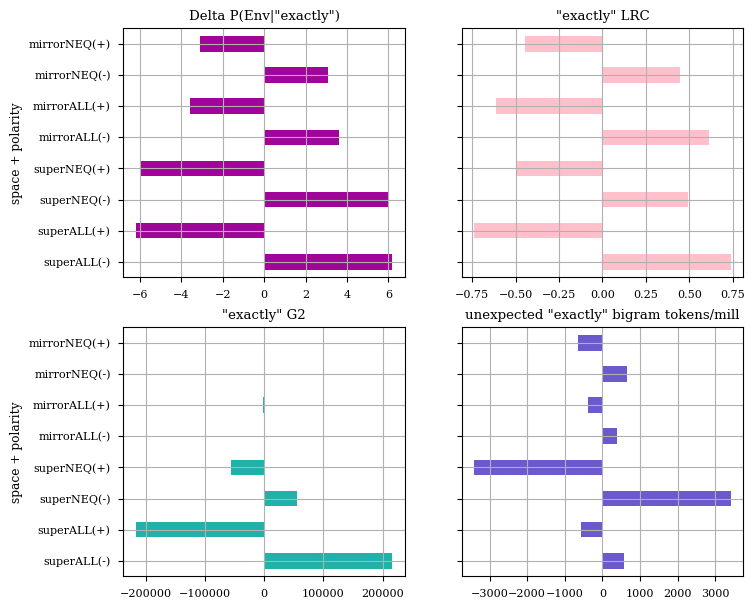

In [16]:
#! pgf image --- used?
exactly_df.columns.name = 'metric'
exactly_df = exactly_df.assign(N_mill=exactly_df.N/(1000000))
# set_my_style(exactly_df.style)
# plt.style.use('dark_background')
# plt.rcParams['font.family'] = 'serif'
_plot_df = exactly_df.copy()
_plot_df.index = _plot_df.index.to_flat_index().to_series().str.join(
    '').str.replace('pos', '(+)').str.replace('neg', '(-)')
fig = _plot_df.filter(regex=r'dP1|L|G|tpm_unexp_f$').plot(
    subplots=True, sharex=False, layout=(3, 2), sharey=True, legend=False,
    kind='barh', colormap='light_rain', grid=True, 
    figsize=(8, 11), fontsize=8, ylabel='space + polarity',
    title=['Delta P(Env|"exactly")', '"exactly" LRC', '"exactly" G2',
           'unexpected "exactly" bigram tokens/mill']
)
fig_path = EXACTLY_IMAGES.joinpath(f'env~exactlyAM_subplots2x2_deltaP-LRC-G2-tpmUnexpF.{timestamp_today()}.pgf')
print(f'Saving plot as:  "{fig_path.relative_to(IMAGE_DIR.parent.parent)}"')
plt.savefig(fig_path, dpi=300, bbox_inches='tight', pad_inches=0.05)
if SHOW_FIGS:
    plt.show()

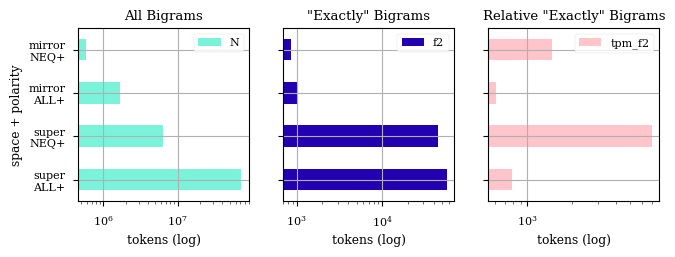

In [17]:
_pol_shared_freqs = _plot_df.filter(['N', 'f2', 'tpm_f2']).drop_duplicates()
_pol_shared_freqs.index = _pol_shared_freqs.index.str.replace(r'r([AN])',r'r\n\1', regex=True).str.strip('(+-)') + '+'
# _pol_shared_freqs

fig = _pol_shared_freqs.plot(
    subplots=True,
    layout=(1,3), 
    grid=True, 
    legend=True, width=0.5,
    # kind='bar', sharex=True,  sharey=False, xlabel='space + polarity', logy=True, 
    kind='barh', sharex=False,  sharey=True, ylabel='space + polarity', logx=True,xlabel='tokens (log)',
    colormap='lisa_frank', figsize=(7.5, 2.25), 
    # fontsize=8, rot=20,
    title=[
           'All Bigrams',
        '"Exactly" Bigrams',
        'Relative "Exactly" Bigrams',
           ]
)

plt.savefig(EXACTLY_IMAGES.joinpath(f'env~exactly-f2N-subplots1x3.{timestamp_today()}.pgf'), 
dpi=300, bbox_inches='tight', pad_inches=0.05)


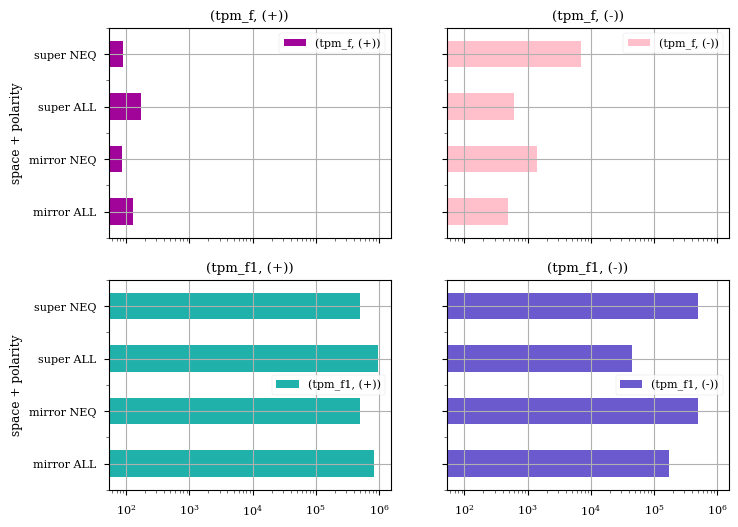

In [18]:
# image not saved
_plot_df_x = _plot_df.filter(['tpm_f', 'tpm_f1']).assign(
    space=_plot_df.index.str.strip(
        '(-+)').str.replace(r'r(?=[AN])', 'r ', regex=True),
    polarity=_plot_df.index.str[-3:]
).set_index(['space', 'polarity']).unstack()
_plot_df_x

fig = _plot_df_x.plot(
    subplots=True, layout=(2,2),
    # legend=False,
   sharey=True, logx=True, sharex=True,
    kind='barh', colormap='light_rain', grid=True, 
    figsize=(8, 6), fontsize=8, ylabel='space + polarity', 
    # title=['Env~"exactly" Joint Frequency (tpm)', 'Env Marginal Frequency (tpm)']
)

In [19]:
# plot_polar_f(exactly_df.unstack(), (7, 2.5), colormap_name='seismic',
#              image_dir=IMAGE_DIR, image_label='exactly')

Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_fSqrt(+)-fSqrt(-)_20250302_23.pgf"
Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_tpmFSqrt(+)-tpmFSqrt(-)_20250302_23.pgf"
Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_unexpFSqrt(+)-unexpFSqrt(-)_20250302_23.pgf"


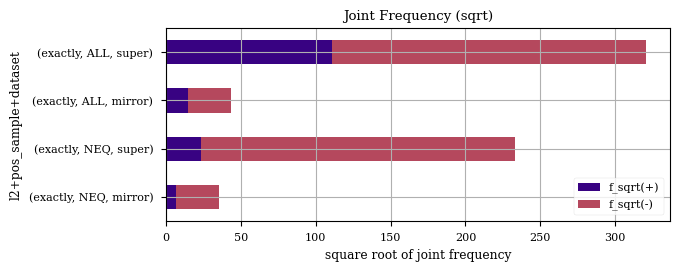

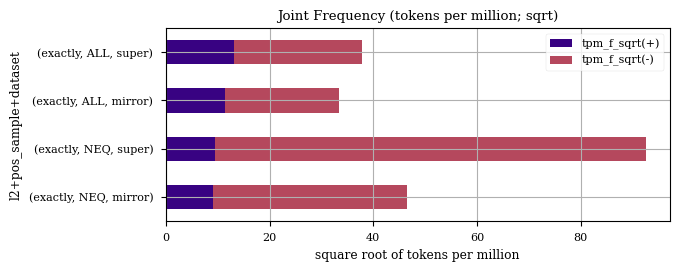

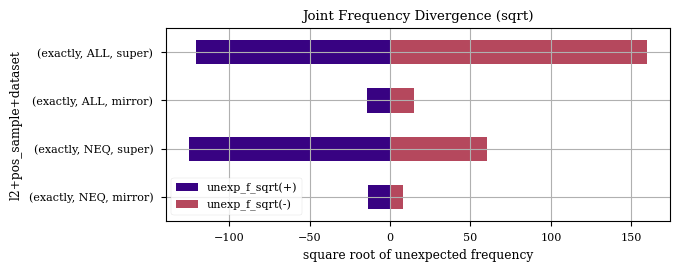

Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_tpmUnexpFSqrt(+)-tpmUnexpFSqrt(-)_20250302_23.pgf"


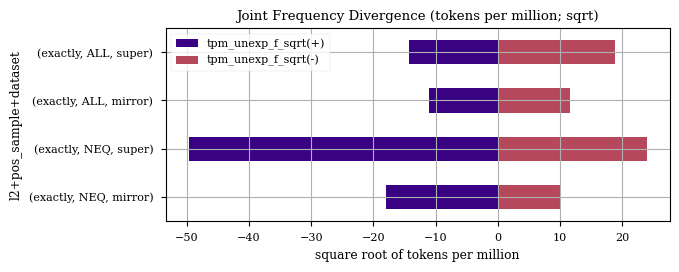

Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_tpmUnexpFSqrt(+)-tpmFSqrt(+)-tpmFSqrt(-)-tpmUnexpFSqrt(-)_20250302_23.pgf"


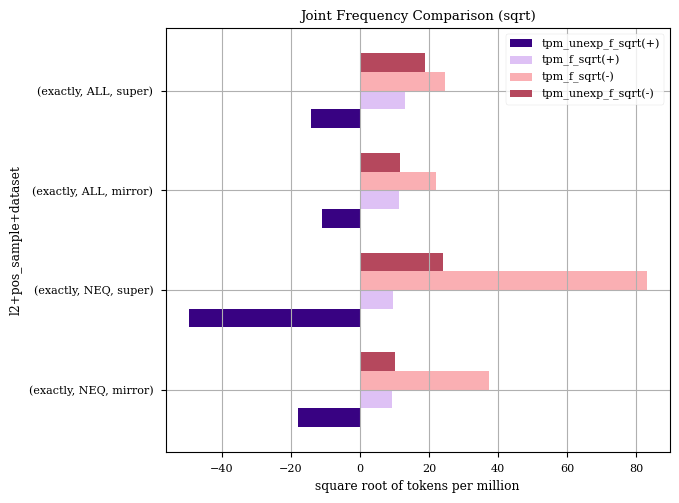

Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_unexpR(+)-unexpR(-)_20250302_23.pgf"


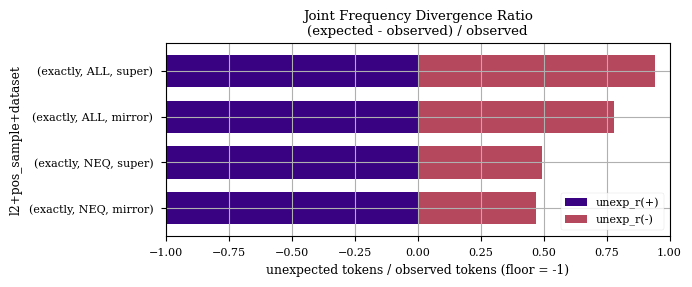

Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_dP1(+)-dP1(-)_20250302_23.pgf"


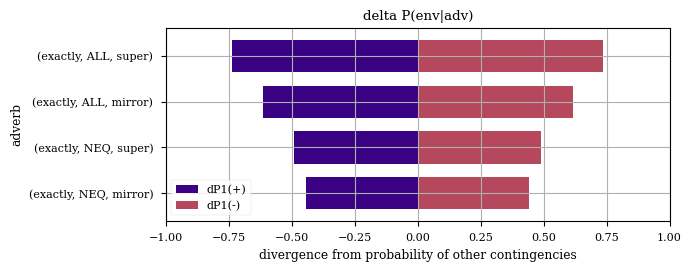

Output Path: "/share/compling/projects/arh234/OverleafDissertex/assets/images/exactly/exactly_LRC(+)-LRC(-)_20250302_23.pgf"


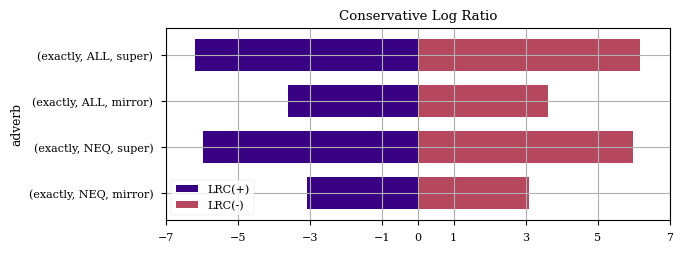

html formatted table saved as: "/share/compling/projects/sanpi/info/writing_links/imports/tables/polar-exactly_AM.by-['l2', 'dataset', 'pos_sample'].25-03-02_23.html"


In [20]:
viz_adv_polar('exactly', exactly_df.join(
    exactly_str_info).reset_index().set_index('space_key'),
    colormap_name='lilac_rose', size_tuple=(6.5, 2.5))

Old table to replace...

|                      approximation evidence | attribute                        | *Absent Negative* (*E superset) |                            | *Present Positive* (@E subset) |                 |
|--------------------------------------------:|:---------------------------------|--------------------------------:|---------------------------:|-------------------------------:|----------------:|
|                                       total | **`amdf.N`**                     |                $^T$`86,330,752` |                            |  $^M$`2,032,082` ($_t$`2.35%`) |                 |
|                          *exactly* subtotal | **`amdf.f2`**                    |                    $^S$`61,599` |                            |      $^A$`1,114` ($_s$`1.81%`) |                 |
|                                 environment |                                  |              $*N^+$, `RBdirect` | $*C_{N^+}$, `not-RBdirect` |                @N, `NEGmirror` | @P, `POSmirror` |
|                        environment subtotal | **`amdf.f1`**                    |                     `3,226,213` |               `83,102,035` |                      `293,963` |     `1,738,105` |
|        environment % of set totals $^{T,M}$ | **`(amdf.f1/amdf.N)*100`**       |                     $_t$`3.74%` |               $_t$`96.26%` |                   $_m$`14.47%` |    $_m$`85.53%` |
|                    *observed other ADV $f$* | **`amdf.N - amdf.f2`**           |                 (*`3,182,578`*) |           (*`83,084,071`*) |                  (*`293,150`*) | (*`1,737,804`*) |
|                      **observed joint $f$** | **`amdf.f`**                     |                $^N$**`43,635`** |           $^C$**`17,964`** |                  $^X$**`813`** |   $^P$**`301`** |
|       % of set *exactly* subtotals $^{S,A}$ | **`(amdf.f/amdf.f2)*100`**       |                    $_s$`70.84%` |               $_s$`29.16%` |                   $_a$`72.98%` |    $_a$`27.02%` |
|       % of superset *exactly* subtotal $^S$ | **`(amdf.f/amdf.super_f2)*100`** |                               ^ |                          ^ |                    $_s$`1.32%` |     $_s$`0.49%` |
| % of same polarity superset tokens $^{N,C}$ | **`(amdf.f/amdf.super_f)*100`**  |                    ($_n$`100%`) |               ($_c$`100%`) |                    $_n$`1.86%` |     $_c$`1.68%` |
|                  total complement of subset | **`(amdf.N - amdf.mirror_N)`**   |                       `293,963` |               `81,363,930` |                          (`0`) |                 |
|              *exactly* complement of subset | **`(amdf.f2 - amdf.mirror_f2)`** |                        `42,822` |                    `17663` |                          (`0`) |                 |

👆 must be extended/replicated with both `ALL` and `NEQ` comparison spaces

In [21]:
xf = exactly_df.filter(regex=r'^[fN]\d?$').sort_index(axis=1)

super_xf = xf.copy().xs('super')
super_xf.columns.name = 'superset'
# super_xf = xf.filter(like='super',axis=0)
# set_my_style(super_xf.style)

mirror_xf = xf.copy().xs('mirror')
mirror_xf.columns.name = 'mirror subset'
# mirror_xf = xf.filter(like='mirror', axis=0)#
# set_my_style(mirror_xf.style)


xf = xf.assign(super_f=xf.index.to_series().apply(lambda x: super_xf.loc[x[1:], 'f']),
               super_f1=xf.index.to_series().apply(
                   lambda x: super_xf.loc[x[1:], 'f1']),
               super_f2=xf.index.to_series().apply(
                   lambda x: super_xf.loc[x[1:], 'f2']),
               mirror_f2=xf.index.to_series().apply(
                   lambda x: mirror_xf.loc[x[1:], 'f2']),
               mirror_N=xf.index.to_series().apply(
                   lambda x: mirror_xf.loc[x[1:], 'N']),
               super_N=xf.index.to_series().apply(
                   lambda x: super_xf.loc[x[1:], 'N']),
               )
tmp_cols = xf.filter(like='r_').columns.to_list()
print(tmp_cols)

# .rename(columns={'f2': 'f2=exactly_subtotal', 'f': 'f=joint_f',
#                  'f1': 'f1=env_subtotal', 'N': 'N=total'})
xf = (xf.assign(OTHER_joint_f=xf.f1-xf.f,
                # OTHER_subtotal=xf.N - xf.f2,
                N_pct_super_N=(xf.N / xf.super_N)*100,
                env_pct_N=(xf.f1 / xf.N) * 100,
                env_pct_super_N=(xf.f1/xf.super_N)*100,
                f_pct_f2=(xf.f / xf.f2) * 100,
                f_pct_super_f2=(xf.f / xf.super_f2)*100,
                f2_pct_super_f2=(xf.f2 / xf.super_f2)*100,
                f1_pct_super_f1=(xf.f1 / xf.super_f1)*100,
                f_pct_super_f=(xf.f / xf.super_f)*100,
                set_diff_f2=xf.f2 - xf.mirror_f2,
                set_diff_N=xf.N - xf.mirror_N,
                )
      .reset_index().set_index(['pos_sample', 'dataset', 'polarity']).sort_index(ascending=False)
      .drop(columns=tmp_cols))

set_my_style(xf.T.filter(like='ALL').style,
             index_font='iosevka ss07')

['super_f', 'super_f1', 'super_f2', 'mirror_f2', 'mirror_N', 'super_N']


In [22]:
set_my_style(xf.T.filter(like='NEQ').style,
             index_font='iosevka ss07')

In [23]:
all_xf = xf.sort_index(ascending=False).xs('ALL')
all_xf.columns.name = '`ALL+`'
set_my_style(all_xf.T)

In [24]:
neq_xf = xf.sort_index(ascending=False).xs('NEQ')
neq_xf.columns.name = '`NEQ+`'
print(neq_xf.T.to_markdown(floatfmt=',.2f', intfmt=','))

| `NEQ+`          |   ('super', 'pos') |   ('super', 'neg') |   ('mirror', 'pos') |   ('mirror', 'neg') |
|:----------------|-------------------:|-------------------:|--------------------:|--------------------:|
| N               |       6,347,362.00 |       6,347,362.00 |          583,470.00 |          583,470.00 |
| f               |             565.00 |          43,813.00 |               49.00 |              813.00 |
| f1              |       3,173,681.00 |       3,173,681.00 |          291,735.00 |          291,735.00 |
| f2              |          44,378.00 |          44,378.00 |              862.00 |              862.00 |
| OTHER_joint_f   |       3,173,116.00 |       3,129,868.00 |          291,686.00 |          290,922.00 |
| N_pct_super_N   |             100.00 |             100.00 |                9.19 |                9.19 |
| env_pct_N       |              50.00 |              50.00 |               50.00 |               50.00 |
| env_pct_super_N |              50.00 |      

In [25]:
set_my_style(
    xf.filter(like='pct')
    .T.style,)

## Polar Propensities of *Exactly* Bigrams

### ⭐ Load `env~bigram` data

In [26]:
polar_bigram_index = ['dataset', 'pos_sample', 'polarity', 'adj']
exactly_bigrams_csv = TOP_AM_DIR.joinpath(
    f'exactly/env~exactly_bigrams_compiled.csv')
exactly_bigrams_parq = exactly_bigrams_csv.with_suffix('.min0x.parq')

raw_exactly_bigrams = None
all_exactly_bigrams = None
if exactly_bigrams_parq.exists():
    all_exactly_bigrams = pd.read_parquet(
        exactly_bigrams_parq, engine='pyarrow')
    print(f'Loaded from prior parquet: "{exactly_bigrams_parq.relative_to(SANPI_HOME)}"')
elif exactly_bigrams_csv.is_file():
    all_exactly_bigrams = pd.reac_csv(exactly_bigrams_csv)
    print(f'Loaded from prior csv: "{exactly_bigrams_csv.relative_to(SANPI_HOME)}"')
else:
    all_exactly_bigrams = load_all_relevant_ams(
        {'exactly', }, unit='bigram', label='exactly')

    updated_eb = extend_freq_cols(all_exactly_bigrams)
    updated_eb = update_amdf(updated_eb, polar=True, frequencies=False)
    updated_eb = updated_eb.loc[:, updated_eb.count() == len(updated_eb)]
    updated_eb.loc[:, updated_eb.count() == len(updated_eb)].to_parquet(
        exactly_bigrams_parq, engine='pyarrow',
        partition_cols=['dataset', 'pos_sample'],
        basename_template='group-{i}.parquet',
        existing_data_behavior='delete_matching')
    if 'tpm_adj_total' not in updated_eb.columns:
        updated_eb['tpm_adj_total'] = tok_per_mill('adj_total', updated_eb)
    updated_eb.to_csv(exactly_bigrams_csv)
    all_exactly_bigrams = updated_eb
all_exactly_bigrams = all_exactly_bigrams.convert_dtypes()

if 'space_key' in all_exactly_bigrams.columns:
    all_exactly_bigrams = all_exactly_bigrams.set_index('space_key')

Loaded from prior parquet: "results/top_AM/exactly/env~exactly_bigrams_compiled.min0x.parq"


```log

+ ALL+sup
RBdirect/bigram/extra/polarized-bigram_ALL-direct_min1x_extra.parq

+ NEQ+sup
RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min1x_extra.parq

+ NEQ+mir
mirror/bigram/extra/polarized-bigram_NEQ-mirror_min1x_extra.parq

+ ALL+mir
mirror/bigram/extra/polarized-bigram_ALL-mirror_min1x_extra.parq

<class 'pandas.core.frame.DataFrame'>
Index: 8961 entries, ALL+sup:NEG~exactly_conducive to ALL+sup:POS~exactly_surprising
Data columns (total 78 columns):
...
All env~exactly_* bigram AM info saved as "/share/compling/projects/sanpi/results/top_AM/exactly_bigrams_compiled.csv"
```
```log
+ ALL+sup
polar/RBdirect/bigram/extra/polarized-bigram_ALL-direct_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/RBdirect/bigram/extra/polarized-bigram_ALL-direct_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/RBdirect/bigram/extra/polarized-bigram_ALL-direct_min0x-exactly_extra.parq"

+ NEQ+sup
polar/RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/RBdirect/bigram/extra/polarized-bigram_NEQ-direct_min0x-exactly_extra.parq"

+ NEQ+mir
polar/mirror/bigram/extra/polarized-bigram_NEQ-mirror_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/mirror/bigram/extra/polarized-bigram_NEQ-mirror_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/mirror/bigram/extra/polarized-bigram_NEQ-mirror_min0x-exactly_extra.parq"

+ ALL+mir
polar/mirror/bigram/extra/polarized-bigram_ALL-mirror_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/mirror/bigram/extra/polarized-bigram_ALL-mirror_min0x-exactly_extra.parq"
  loading from prior exhaustive processing in "polar/mirror/bigram/extra/polarized-bigram_ALL-mirror_min0x-exactly_extra.parq"
```

#### Investigate Marginal Frequencies

> Filter to only bigrams exceeding a set floor

In [27]:
def describe_strings(_df):
    # print(f'Minimum joint frequency: {_df.f.min():,}')
    # print(f'Minimum MEAN joint frequency (by polarity): {_df.f_m.min():,}')
    print(f'Minimum bigram subtotal: {_df.f2.min():,}')
    print(f'Minimum MEAN bigram subtotal: {_df.f2_m.min():,}')
    print(f'{_df.l2.nunique():,} total unique "exactly ADJ" bigrams attested')
    return set_my_style(_df.select_dtypes('string').describe().T.convert_dtypes().style, index_font='')

describe_strings(all_exactly_bigrams)

Minimum bigram subtotal: 1
Minimum MEAN bigram subtotal: 0.25
3,995 total unique "exactly ADJ" bigrams attested


> 🚩 `exactly_bigrams` filtered to only adjectives with a corresponding _mean_ bigram per million subtotal (`tpm_f2_m`) which is at least equal to the **40th percentile** of the all bigram per million subtotals.

In [28]:
Q=0.4
quantile_tpm_f2_floor = all_exactly_bigrams[all_exactly_bigrams.f2 > 0].tpm_f2.quantile(Q)

print(all_exactly_bigrams.filter(regex=r'^[tpm_]*(f2)_?m?$').describe().filter(regex=r'[m\d]', axis=0).to_markdown(floatfmt=',.3f', intfmt=',', tablefmt='rounded_outline'))
print(f'bigram subtotal {str(Q).strip("0.")+("0" if len(str(Q))==3 else "")}th percentile = {quantile_tpm_f2_floor:.6f} (bigram tokens per million)')
# print(f'  {quantile_tpm_f2_floor * (10e6):,.0f} tokens')
# print((all_exactly_bigrams.copy().set_index('space')
#        .N.drop_duplicates().multiply(quantile_tpm_f2_floor))
#       .to_frame('percentile applied to each comparison space (N)').to_markdown(tablefmt='rounded_outline', floatfmt=',.3f'))



╭──────┬───────────┬───────────┬───────────┬────────────╮
│      │        f2 │    tpm_f2 │      f2_m │   tpm_f2_m │
├──────┼───────────┼───────────┼───────────┼────────────┤
│ mean │    12.219 │     1.177 │    10.379 │      1.027 │
│ min  │     1.000 │     0.014 │     0.250 │      0.003 │
│ 25%  │     1.000 │     0.014 │     0.500 │      0.043 │
│ 50%  │     1.000 │     0.158 │     1.000 │      0.086 │
│ 75%  │     4.000 │     0.472 │     2.500 │      0.300 │
│ max  │ 8,840.000 │ 1,385.930 │ 4,483.250 │    462.623 │
╰──────┴───────────┴───────────┴───────────┴────────────╯
bigram subtotal 40th percentile = 0.097274 (bigram tokens per million)


In [29]:

exactly_bigrams = all_exactly_bigrams.copy().loc[
    all_exactly_bigrams.f2_m >= 10, :]

# exactly_bigrams = all_exactly_bigrams.copy().loc[all_exactly_bigrams.tpm_f2_m >
#                                       quantile_tpm_f2_floor, :]
print('\n***\nAfter limiting based on bigram subtotals\n***')
print(exactly_bigrams.filter(regex=r'^[tpm_]*(f2)_?m?$').describe().filter(regex=r'[m\d]', axis=0).to_markdown(floatfmt=',.2f', intfmt=',', tablefmt='rounded_outline'))
describe_strings(exactly_bigrams)


***
After limiting based on bigram subtotals
***
╭──────┬──────────┬──────────┬──────────┬────────────╮
│      │       f2 │   tpm_f2 │     f2_m │   tpm_f2_m │
├──────┼──────────┼──────────┼──────────┼────────────┤
│ mean │    88.89 │     8.48 │    82.02 │       7.92 │
│ min  │     1.00 │     0.26 │    10.00 │       0.37 │
│ 25%  │     2.00 │     0.60 │    15.00 │       1.55 │
│ 50%  │    27.00 │     1.79 │    23.25 │       2.58 │
│ 75%  │    55.00 │     5.43 │    53.00 │       4.82 │
│ max  │ 8,840.00 │ 1,385.93 │ 4,483.25 │     462.62 │
╰──────┴──────────┴──────────┴──────────┴────────────╯
Minimum bigram subtotal: 1
Minimum MEAN bigram subtotal: 10.0
306 total unique "exactly ADJ" bigrams attested


In [30]:
all_exactly_bigrams = eval_sig(all_exactly_bigrams)
show_example_l2(
    all_exactly_bigrams,
    adv='exactly', 
    example_l2=(all_exactly_bigrams
                .loc[all_exactly_bigrams.f2_m >= 50, ['l2']]
                .sample(1).squeeze()),
    index_order=['l2', 'dataset', 'pos_sample',
                    'adj_total', 'f2', 'direction', 'polarity', 'f'],
    columns=['adj_total','P1',  'dP1', 'LRC', 'f2', 'unexp_r'], 
    call_from=get_call_comment(ist()[0]),
    transpose=True, 
    latex=True)

outdir: exactly/env-l2-examples


Caption: Polarity sensitivity of \textit{\textbf{exactly common}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_common_example-table.2025-03-02.tex



L2                 exactly_common                                                   
Dataset                     super                          mirror                   
Pos Sample                    NEQ            ALL              NEQ           ALL     
Adj Total                  34621          513728           1862          7547       
F2                            156            158              2             2       
Direction                   repel attract  repel attract insignif      insignif     
Polarity                      pos     neg    pos     neg      pos  neg      pos  neg
F                             1       155    3       155      0    2        0    2  
Env~Exactly Common                                                                  
P1                           0.01    0.99   0.02    0.98     0.00 1.00     0.00 1.00
dP1                         -0.49    0.49  -0.94    0.94    -0.50 0.50    -0.83 0.83
LRC                         -2.90    2.90  -7.00    7.00     0.00 0.00     0.00 0.00
unexp_r                     -1.00    0.50  -1.00    0.96    -1.00 0.50    -1.00 0.83

### Plot Adjective/Bigram Marginal Frequencies

#### Superset

##### ALL of Superset (Bigrams with *exactly*)

In [31]:
# plot_sequential_margins(all_exactly_bigrams, dataset='super')

##### NEQ Sample of Superset (Bigrams with *exactly*)

In [32]:
# plot_sequential_margins(all_exactly_bigrams, dataset='super', pos_sample='NEQ')

##### Restricted by Bigram Subtotal

mean bigram subtotal as `tpm_f2_m` $>$ 40th percentile of bigram subtotals `tpm_f2.quantile(0.4)`

In [33]:
# plot_sequential_margins(exactly_bigrams)

In [34]:
# plot_sequential_margins(all_exactly_bigrams, dataset='mirror')


# plot_sequential_margins(all_exactly_bigrams, dataset='mirror')

### ⭐ Investigate Significance Rates of Polarity Sensitive Bigrams

In [35]:
all_exactly_bigrams = eval_sig(all_exactly_bigrams)
# style_crosstab(all_exactly_bigrams, ['pos_sample', 'dataset',], ['direction','polarity'], 'adj', 
#                aggfunc='count', sort=False, axis=None,
#                group=True, cmap = 'BuPu', cmap2=None, cmap3=None,
#                prefilter_label='exactly/ExactlyBigramsSignif', latex=True)

exactly_bigrams = eval_sig(exactly_bigrams)
# style_crosstab(exactly_bigrams, ['pos_sample', 'dataset',], ['direction','polarity'], 'adj', 
#                aggfunc='count', sort=False, axis=None,
#                group=True, cmap = 'YlGnBu', cmap2=None, cmap3=None,
#                prefilter_label='exactly/ExactlyBigramsSignif_f2Limited', latex=True)
#// signif_counts = get_sensitive_bigram_totals(all_exactly_bigrams)
#// sty = format_zeros(set_my_style(signif_counts.style
#//                    # f'✕ {sig_df.space.nunique()} spaces ✕ 2 polarities'
#//                    .background_gradient(subset=signif_counts.columns.to_list()[:4], 
#//                                         axis=None, cmap='GnBu', low=0.25,)
#//                    .background_gradient(subset=['total'], cmap='Blues', axis=0)
#//                    .background_gradient(subset=['ratio'], cmap='Greens', axis=0)
#//                    .highlight_between(left=-0.9, right=0.1, props='opacity:80%'), 
#//                    caption_side='bottom', caption_align='left',
#//                    caption=(
#//                        f'Polar sensitivities across {len(all_exactly_bigrams):,} evaluations:<br/>'
#//                        f'• <i>{all_exactly_bigrams.l2.nunique():,} unique "exactly" bigrams</i><br/>'
#//                        '• <i>minimum bigram subtotal = '
#//                        f'{all_exactly_bigrams.filter(like="ALL+sup", axis=0).f2.min()}</i>')
#//                    ))
#// save_html(sty,

__ = display_sensitive_totals(all_exactly_bigrams, latex=True)

Caption: Polar sensitivities across 16,758 evaluations\\* <i>3,995 unique "exactly" bigrams</i>\\* <i>minimum bigram subtotal in any space = 1</i>\\* <i>minimum bigram subtotal in <u>superset</u> = 1</i>\\* <i>minimum</i> <u>mean</u> <i>bigram subtotal = 0</i>


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/exactly_signif-counts-01f2-00f2m.2025-03-02.tex



[👆 $\LaTeX$ output: No minimum frequencies](/share/compling/projects/sanpi/info/writing_links/latex/tables/exactly/signif_counts/exactly_signif-counts-01f2-00f2m.2025-01-21.tex)

[👇 $\LaTeX$ output: *average* bigram subtotal $\geq 10$](/share/compling/projects/sanpi/info/writing_links/latex/tables/exactly/signif_counts/exactly_signif-counts-01f2-10f2m.2025-01-21.tex)

In [36]:
__ = display_sensitive_totals(exactly_bigrams, latex=True)

# __ = save_html(
#     display_sensitive_totals(exactly_bigrams), 
#           f'DirectionalSignificance_MinF2mean={exactly_bigrams.f2_m.min():.0f}_counts',
#           'ExactlyBigramsSignif')

Caption: Polar sensitivities across 1,850 evaluations\\* <i>306 unique "exactly" bigrams</i>\\* <i>minimum bigram subtotal in any space = 1</i>\\* <i>minimum bigram subtotal in <u>superset</u> = 19</i>\\* <i>minimum</i> <u>mean</u> <i>bigram subtotal = 10</i>


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/exactly_signif-counts-01f2-10f2m.2025-03-02.tex



In [37]:
exactly_bigrams_limit = exactly_bigrams[exactly_bigrams.f2>=20]
# limit_signif_counts = get_sensitive_bigram_totals(exactly_bigrams_limit)

# sty = format_zeros(set_my_style(limit_signif_counts.style
#                    # f'✕ {sig_df.space.nunique()} spaces ✕ 2 polarities'
#                    .background_gradient(subset=limit_signif_counts.columns.to_list()[:4], 
#                                         axis=None, cmap='GnBu')
#                 #    .highlight_between(left=-0.9, right=0.1, props='opacity:80%')
#                    .background_gradient(subset=['total'], cmap='Blues', axis=0)
#                    .background_gradient(subset=['ratio'], cmap='Greens', axis=0),
#                    caption=(
#                        f'Polar sensitivities across {len(exactly_bigrams_limit):,} evaluations:<br/>'
#                        f'<i>{exactly_bigrams_limit.l2.nunique():,} unique "exactly" bigrams</i><br/>'
#                        f'<i>minimum bigram subtotal in any space = {exactly_bigrams_limit.f2.min()}</i><br/>'
#                        f'<i>minimum bigram subtotal in superset = {exactly_bigrams_limit.filter(like="ALL+sup", axis=0).f2.min()}</i>')
#                    ))

__ = display_sensitive_totals(exactly_bigrams_limit, latex=True)
# __ = save_html(display_sensitive_totals(exactly_bigrams_limit), 
#           f'DirectionalSignificance_MinF2={exactly_bigrams_limit.f2.min()}_counts',
#           'ExactlyBigramsSignif')

Caption: Polar sensitivities across 1,216 evaluations\\* <i>302 unique "exactly" bigrams</i>\\* <i>minimum bigram subtotal in any space = 20</i>\\* <i>minimum bigram subtotal in <u>superset</u> = 20</i>\\* <i>minimum</i> <u>mean</u> <i>bigram subtotal = 10</i>


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/exactly_signif-counts-20f2-10f2m.2025-03-02.tex



[👆 $\LaTeX$ output of most limited "polarity sensitive" totals: bigram subtotal $\geq 20$](/share/compling/projects/sanpi/info/writing_links/latex/tables/exactly/signif_counts/exactly_signif-counts-20f2-10f2m.2025-01-21.tex)

In [38]:
for _adj in ({'sure', 'opposite', 'double', #'conducive', 'right', 'fair', 
            #  'equal', 'parallel', 'true', 'cheap', 'identical', 'alike',
            #  'shy', 'new', 'clear', 'happy', 'ideal', 'zero', 'enough', 'halfway'
             }
            #  .union(ERA)
             ):
    show_example_l2(
        all_exactly_bigrams, adv='exactly', example_l2=f'exactly_{_adj}',
        index_order=['l2',
                     'pos_sample','dataset',  'direction', 'polarity', 
                     'adj_total', 'f2','f'],
        columns=['adj_total', 'P1',  'dP1', 'LRC', 'f2', 'unexp_r'], transpose=True,
        call_from=get_call_comment(ist()[0]),
        latex=True)

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly double}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_double_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly opposite}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_opposite_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly sure}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_sure_example-table.2025-03-02.tex



In [39]:
pos_lean_bigrams_list = (all_exactly_bigrams
                         .loc[(all_exactly_bigrams.dP1 > 0) & (all_exactly_bigrams.f2_m > 2)]
                         .filter(like='POS', axis=0)).l2.to_list()
pos_lean_bigrams = (all_exactly_bigrams.filter(like='POS', axis=0)
                    .loc[all_exactly_bigrams.l2.isin(pos_lean_bigrams_list), :])
# (pos_lean_bigrams.value_counts(['adj', 'f2_m', 'dP1m', 'LRCm']).to_frame()
#                     .sort_index(level=['LRCm', 'dP1m'])
#                     .reset_index(['dP1m', 'LRCm'])
#                     .droplevel('f2_m'))

In [40]:
show_example_l2(all_exactly_bigrams, 'exactly_contrary',
                transpose=True,
                index_order=['l2', 'dataset', 'pos_sample',
                             'adj_total', 'f2', 'direction', 'polarity', 'f'],
                columns=['adj_total', 'P1',  'dP1', 'LRC', 'f2', 'unexp_r'],
                call_from=get_call_comment(ist()[0]),
                latex=True)

outdir: ADV/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly contrary}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~exactly_contrary_example-table.2025-03-02.tex



L2                   exactly_contrary                                    
Dataset                         super                        mirror      
Pos Sample                        NEQ            ALL            ALL      
Adj Total                        541            6432           258       
F2                                 2              58             1       
Direction                    insignif       insignif       insignif      
Polarity                          pos   neg      pos   neg      pos   neg
F                                  2     0        58    0        1     0 
Env~Exactly Contrary                                                     
P1                               1.00  0.00     1.00  0.00     1.00  0.00
dP1                              0.50 -0.50     0.04 -0.04     0.17 -0.17
LRC                              0.00  0.00     0.00  0.00     0.00  0.00
unexp_r                          0.50 -1.00     0.04 -1.00     0.17 -1.00

In [41]:
show_example_l2(all_exactly_bigrams,  pos_lean_bigrams.drop_duplicates('l2').sample(1).l2.squeeze(),
                 columns=['P1', 'dP1', 'LRC', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True, precision=2,adv='exactly',
                call_from=get_call_comment(ist()[0]),
                index_order = ['l2', 'dataset', 'pos_sample', 'adj_total', 'f2', 'direction', 'polarity'], 
                latex=True)

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly related}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_related_example-table.2025-03-02.tex



L2                  exactly_related                                      
Dataset                       super                          mirror      
Pos Sample                      NEQ            ALL              ALL      
Adj Total                    14257          104872           3417        
F2                               66             77               2       
Direction                     repel attract  repel attract insignif      
Polarity                        pos     neg    pos     neg      pos   neg
Env~Exactly Related                                                      
P1                             0.05    0.95   0.18    0.82     1.00  0.00
dP1                           -0.45    0.45  -0.77    0.77     0.17 -0.17
LRC                           -1.12    1.12  -4.57    4.57     0.00  0.00
tpm_unexp_f                   -4.73    4.73  -0.83    0.83     0.21 -0.21
unexp_r                       -1.00    0.48  -1.00    0.95     0.17 -1.00

### Visualize polar sensitivity by marginal frequency bins

In [42]:
freq_cols = ['f','f_m','f2','f2_m','adj_total','tpm_f', 'tpm_f_m','tpm_f2', 'tpm_f2_m','tpm_adj_total']
all_exactly_bq = all_exactly_bigrams.copy().filter(COLUMN_LIST+['direction', 'LRC!=0'] + freq_cols)
for freq_col in freq_cols:
    all_exactly_bq = designate_bins(all_exactly_bq, freq_col)


##### `f2_quantile_info`

In [43]:
set_my_style(style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f2_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='exactly/signif_counts/neg-exactly-bigrams', 
               sort=False, index_font='', 
               latex=True))

Caption: Crosstabulated <code>adj</code> (as count)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/neg-exactly-bigrams/f2_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-03-02.tex



##### `f2_m_quantile_info`

In [44]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['f2_m_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
#                value_col='adj', aggfunc='count', 
#                axis=None, group=True, group_col='direction',
#                cmap='PuRd', cmap2='bone_r', latex=True,
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='', 
#                )

##### `tpm_f2_quantile_info`

In [45]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['tpm_f2_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
#                value_col='adj', aggfunc='count', 
#                axis=None, group=True, group_col='direction',
#                cmap='PuRd', cmap2='bone_r',latex=True,
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='')

##### `tpm_f2_m_quantile_info`

In [46]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['tpm_f2_m_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
#                value_col='adj', aggfunc='count', 
#                axis=None, group=True, group_col='direction',
#                cmap='PuRd', cmap2='bone_r',latex=True,
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='')

##### `f_quantile_info`

In [47]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',latex=True,
               prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False)

Caption: Crosstabulated <code>adj</code> (as count)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/neg-exactly-bigrams/f_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-03-02.tex



##### `tpm_f_quantile_info`

In [48]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['tpm_f_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
#                value_col='adj', aggfunc='count', 
#                axis=None, group=True, group_col='direction',
#                cmap='PuRd', cmap2='bone_r',latex=True,
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='')

##### `f_m_quantile_info`

In [49]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['f_m_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
#                value_col='adj', aggfunc='count', 
#                axis=None, group=True, group_col='direction',
#                cmap='PuRd', cmap2='bone_r',latex=True,
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='')

##### `adj_total_quantile_info`

In [50]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['adj_total_quantile_info', ], ['polarity','direction','dataset','pos_sample'],  
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='BuGn',cmap2='GnBu',
               prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='', 
               latex=True)

Caption: Crosstabulated <code>adj</code> (as count)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/neg-exactly-bigrams/adj_total_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-03-02.tex



In [51]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['tpm_adj_total_quantile_info', ], ['direction','dataset','pos_sample'],  
#                value_col='adj', aggfunc='count', 
#                axis=None, group=True, latex=True,
#                cmap='BuGn',cmap2='GnBu',
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='')

##### Total Significance by Quantiles

In [52]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f2_quantile_info'],['polarity','direction'],   
               value_col='adj', aggfunc='count',
               axis=None, group=True, group_col='direction',
               cmap='PuRd', cmap2='bone_r',
               prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='', 
               latex=True
               )

Caption: Crosstabulated <code>adj</code> (as count)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/neg-exactly-bigrams/f2_quantile_info_adj-count_polarity-direction_color-table_grouped.2025-03-02.tex



In [53]:
style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['adj_total_quantile_info'],['polarity','direction'],   
               value_col='adj', aggfunc='count',
               axis=None, group=True, group_col='direction',
               cmap='BuGn',cmap2='GnBu',
               prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font='',
               latex=True
               )

Caption: Crosstabulated <code>adj</code> (as count)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/neg-exactly-bigrams/adj_total_quantile_info_adj-count_polarity-direction_color-table_grouped.2025-03-02.tex



In [54]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['f_m_quantile_info'],['polarity','direction'],   
#                value_col='adj', aggfunc='count',
#                axis=None, group=True, group_col='direction',
#                cmap='PuRd', cmap2='bone_r',latex=True,
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', sort=False, index_font=''
#                )

In [55]:
# style_crosstab(all_exactly_bq.assign(direction=all_exactly_bq.direction.astype('string'))
#                .filter(like='NEG', axis=0),
#                ['tpm_adj_total_quantile_info', ], [
#                    'direction', 'dataset', 'pos_sample'],
#                value_col='adj', aggfunc='count',
#                axis=None, group=True,
#                cmap='BuGn', cmap2='GnBu',latex=True,
#                prefilter_label='exactly/signif_counts/neg-exactly-bigrams', 
#                sort=False, index_font='')

#### direction of significance + `adj_total` quantiles by `f2` quantiles

In [56]:
style_crosstab(
    (all_exactly_bq.filter(like='ALL+sup:NEG', axis=0)
     .assign(direction=all_exactly_bq.direction.astype('string'))),
    ['direction', 'adj_total_quantile_info'], 
    ['f2_quantile_info',],
    value_col='adj', aggfunc='count',
    cmap='BuPu', index_font='', 
    cmap2='bone_r',
    #    cmap='green_kw9_smoothie_r',
    axis=None, group=False,latex=True,
    prefilter_label='exactly/signif_counts/neg-exactly-bigrams/superALL', sort=False)

Caption: Crosstabulated <code>adj</code> (as count)<br/>color gradient set by <u>whole table</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/neg-exactly-bigrams/superALL/direction-adj_total_quantile_info_adj-count_f2_quantile_info_color-table.2025-03-02.tex



#### direction of significance + `f2` quantiles by `f_m` quantiles

In [57]:
# style_crosstab(
#     (all_exactly_bq.filter(like='ALL+sup:NEG', axis=0)
#      .assign(direction=all_exactly_bq.direction.astype('string'))),
#     ['direction','f2_quantile_info'], 
#     [ 'f_m_quantile_info',],
#     value_col='adj', aggfunc='count',
#     cmap='BuPu', index_font='',
#     cmap2='bone_r',
#     #    cmap='green_kw9_smoothie_r',
#     axis=None, group=False,latex=True,
#     prefilter_label='exactly/signif_counts/neg-exactly-bigrams/superALL', sort=False)

#### direction of significance + `tpm_adj_total` quantiles by `tpm_f2` quantiles

In [58]:
# style_crosstab(
#     (all_exactly_bq.filter(like='ALL+sup:NEG', axis=0)
#      .assign(direction=all_exactly_bq.direction.astype('string'))),
#     ['direction', 'tpm_adj_total_quantile_info'], 
#     ['tpm_f2_quantile_info',],
#     value_col='adj', aggfunc='count',
#     cmap='BuPu', index_font='',
#     #    cmap='green_kw9_smoothie_r',
#     axis=None, group=False,latex=True,
#     prefilter_label='exactly/signif_counts/neg-exactly-bigrams/superALL', sort=False)

In [59]:
exactly_bigrams = designate_bins(exactly_bigrams, 'f2')
exactly_bigrams = designate_bins(exactly_bigrams, 'adj_total')

In [60]:
style_crosstab(exactly_bigrams.assign(direction=exactly_bigrams.direction.astype('string'))
               .filter(like='NEG', axis=0),
               ['f2_quantile_info', ],['polarity','direction','dataset','pos_sample'],   
               value_col='adj', aggfunc='count', 
               axis=None, group=True, group_col='direction',
               cmap='BuPu',cmap2='bone_r',
               prefilter_label='exactly/signif_counts/f2-restricted/neg-exactly-bigrams', sort=False, index_font='', 
               latex=True)

Caption: Crosstabulated <code>adj</code> (as count)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/f2-restricted/neg-exactly-bigrams/f2_quantile_info_adj-count_polarity-direction-dataset-pos_sample_color-table_grouped.2025-03-02.tex



### ⭐ Identify Most Polarity Sensitive *exactly* bigrams

In [61]:
exactly_bigrams['f2_max'] = exactly_bigrams.adj.map(
        all_exactly_bigrams[['adj','f2']].groupby('adj').max().squeeze())

<style>
    green {color: green;}
</style>
📌 **Note**  
To be considered as a top "polar sensitive" pairing ADJ, \
the <green>maximum bigram subtotal (i.e. superset ALL `f2`) must be at least **<u>50 tokens</u>**</green>

In [62]:
eval_metrics = ['dP1m', 'LRCm']
# eval_metrics = ['dP1m', 'LRCm', 'G2m']
adj_m = (exactly_bigrams
         .loc[(exactly_bigrams.f2_max >= 50), :]
         .loc[exactly_bigrams.direction != 'insignif', :]
         .drop_duplicates('polar_l2')
         .set_index(['polarity', 'adj'])
         .filter(regex=r'[m]$'))
adj_m[eval_metrics + ['f2_m']].describe()

dP1m   LRCm     f2_m
count 252.00 252.00   252.00
mean    0.00   0.00   138.95
std     0.58   2.34   439.30
min    -0.70  -7.10    20.75
25%    -0.68  -2.14    36.25
50%    -0.00   0.00    49.88
75%     0.68   2.14    87.00
max     0.70   7.10 4,483.25

In [63]:
bigram_skews = pd.DataFrame(adj_m.round(3).nlargest(13, pd.Series([m]+ eval_metrics).drop_duplicates())[m]
                     for m in eval_metrics).T
adj_in_sensitive_bigrams = bigram_skews.index.get_level_values('adj').to_series().drop_duplicates()

bigram_skews = bigram_skews.reset_index(level='polarity').assign(
    f2_m = adj_m.loc[bigram_skews.index, 'f2_m'].to_list(),
    f2_max=bigram_skews.index.get_level_values('adj').to_series().map(
        all_exactly_bigrams[['adj','f2']].groupby('adj').max().squeeze()),
    # f2_min=bigram_skews.index.get_level_values('adj').to_series().map(
    #     all_exactly_bigrams[['adj','f2']].groupby('adj').min().squeeze()),
    # adj_total_max=bigram_skews.index.get_level_values('adj').to_series().map(
    #     all_exactly_bigrams[['adj','adj_total']].groupby('adj').max().squeeze()),
    # adj_total_min=bigram_skews.index.get_level_values('adj').to_series().map(
    #     all_exactly_bigrams[['adj','adj_total']].groupby('adj').min().squeeze())
    )
bigram_skews = bigram_skews.sort_values('f2_m', ascending=False).reset_index().set_index(['polarity','adj']).head(25)

display(format_zeros(format_negatives(set_my_style(
    bigram_skews.convert_dtypes(), precision=3,
    caption = ('<b>25 Most Polarity Sensitive Adjectives<br/>'
                 'under <i>Exactly</i> Modification</b><br/>'
                 '<i>selected by the polar mean of each metric<br/>'
                 'and sorted by the maximum bigram subtotal (<code>f2</code>)</i>')
    ).background_gradient('RdPu'))))

top_polar_adj = list(bigram_skews.index.get_level_values('adj'))
TOP_POLAR_ADJ_PATH.write_text('\n'.join(top_polar_adj), encoding='utf8')
print(f'Top Polar Adjective selection saved as\n  "{TOP_POLAR_ADJ_PATH}"')

Top Polar Adjective selection saved as
  "/share/compling/projects/sanpi/results/top_AM/top25_exactly_polar_adj.txt"


In [64]:
save_latex_table(
    (all_exactly_bigrams.filter(like=':NEG~', axis=0).loc[
        (all_exactly_bigrams.adj.isin(top_polar_adj)),
        ['polarity', 'adj', 'LRCm', 'dP1m', 'P1m', 'G2m','f_m', 'f2_m']
    ].set_index(['polarity', 'adj'])
     .drop_duplicates()#.stack().unstack(['polarity',-1])
     .sort_values('LRCm', ascending=False)
     .assign(rank=range(1,K+1))
     .reset_index()
    #  .rename(columns={'deltaP_mean': '∆P avg', 
    #                 #   'index':'rank',
    #                 'LRCm': 'mean<br/>LRC',
    #                 'unexp_r_m': 'mean<br/>unexpected/observed<br/>tokens ratio',
    #                  'dP1m':'mean<br/>backwards<br/>∆P',
    #                  'P1m':'mean<br/>backwards<br/>P',
    #                  'G2m':'mean<br/>G²',
    #                  'f_m':'mean<br/>joint<br/>frequency',
    #                  'f2_m':'mean<br/>bigram<br/>subtotal',
    #                 #  'dP2':'∆P(ADJ|x)',
    #                 #  'P2':'P(ADJ|x)',
    #                  'adj':'ADJ'})
    .set_index(['polarity', 'rank', 'adj']).droplevel(level='polarity', axis=0)
    .style.background_gradient('YlGn', axis=0)),
    call_comment=get_call_comment(ist()[0]),
    caption = (f'Top {K} Most Negative Polarity Sensitive' + '\\textit{Exactly *} Bigrams\\\\'
               +'selected by cross-space means of\\\\LRC (\\cmtt{LRCm}) \& backwards $\\Delta P$ (\\cmtt{dP1m})'),
          latex_stem='TopNEGPolarExactlyADJ-meanAMs', latex_subdir='exactly/exactly-bigrams', 
          verbose=True)

Caption: Top 25 Most Negative Polarity Sensitive\textit{Exactly *} Bigrams\\selected by cross-space means of\\LRC (\cmtt{LRCm}) \& backwards $\Delta P$ (\cmtt{dP1m})


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactly-bigrams/TopNEGPolarExactlyADJ-meanAMs.2025-03-02.tex



PosixPath('/share/compling/projects/arh234/OverleafDissertex/assets/tables/exactly/exactly-bigrams/TopNEGPolarExactlyADJ-meanAMs.2025-03-02.tex')

In [65]:
polar_skewed_bigram_adj = bigram_skews.index.get_level_values('adj').to_series().reset_index(drop=True)
polar_skewed_bigram_adj.index += 1
set_my_style(polar_skewed_bigram_adj.to_frame('Adjectives Most Polar Sensitive<br/>under Exactly Modification<br/>(<i>descending marginal frequency <code>f2</code></i>)')
             .style, data_font='CMU classical serif', 
             index_font='CMU bright', col_font='cmu bright')

In [66]:
try:
    all_exactly_bigrams = all_exactly_bigrams.assign(
        tpm_f2_m_quantile=all_exactly_bq.tpm_f2_m_quantile
    )
except NameError: 
    pass
skewed_bigrams = all_exactly_bigrams.loc[all_exactly_bigrams.adj.isin(polar_skewed_bigram_adj), :]

# sty = set_my_style(
#     skewed_bigrams.reset_index().drop_duplicates(
#         'adj').set_index(all_exactly_bigrams.filter(['polarity', 'tpm_f2_m_quantile', 'adj']).columns.to_list())
#     .filter(regex=r'([PGR][\dC]|(^(unexp_f|f2?)_))m$').sort_values('LRCm', ascending=False).sort_index(axis=1)
#     .round(2).stack().unstack(['polarity', -1]),
#     precision=2
# ).background_gradient(cmap='gnuplot2', high=0.1, low=0.02).set_caption(
#     '<b>25 Most Polarity Sensitive Adjectives under <i>Exactly</i> Modification</b><br/>'
#     + 'sorted by polar mean LRC (<code>LRCm</code>)</i>')
# # save_html(
# #     sty, f'25mostPolarSensitive_meanAM-f_color_{timestamp_today()}.html', 'ExactlyBigrams_skewed')
# # _html_out = SANPI_HOME.joinpath(
# #     f'info/writing_links/imports/tables/ExactlyBigrams/25mostPolarSensitive_meanAM-f_color_{timestamp_today()}.html')
# # sty.to_html(_html_out)
# # print(f'Stylized table saved as:\n  "{_html_out.relative_to(WRITING_LINKS)}"')
# sty
# style_crosstab(skewed_bigrams,
#                ['adj'],
#                ['dataset', 'pos_sample','polarity'],
#                sort_col_vals=('super', 'ALL', 'neg'),
#                value_col='f',
#             #    group=False,
#                axis=0,
#                cmap='CMRmap', mark_zeros=True,
#                aggfunc='mean',
#                prefilter_label='exactly/ExactlyBigrams_skewed')
# style_crosstab(skewed_bigrams,
#                ['adj'],
#                ['dataset', 'pos_sample'],
#                sort_col_vals=('super', 'ALL'),
#                value_col='f2',
#             #    group=False,
#                axis=0, precision=1,
#                cmap='ocean_r', 
#                mark_zeros=True,
#                aggfunc='mean',
#                prefilter_label='exactly/ExactlyBigrams_skewed')
# style_crosstab(skewed_bigrams.loc[skewed_bigrams.polarity == 'neg'],
#                ['adj', 'LRCm'],
#                ['polarity', 'dataset','pos_sample'],
#                sort_col_vals=('neg', 'super', 'ALL'),
#                value_col='LRC',
#                group=False,
#                axis=None,
#                cmap='BrBG',
#                aggfunc='mean', index_font = '',
#                prefilter_label='exactly/ExactlyBigrams_skewed-Neg-only', 
#                latex=True)
# style_crosstab(skewed_bigrams[skewed_bigrams.polarity=='neg'],
#                ['adj', 'dP1m'],
#                ['polarity', 'dataset','pos_sample'],
#                sort_col_vals=('neg', 'super', 'ALL'),
#                value_col='dP1',
#                group=True, group_col='pos_sample',
#                axis=None,
#                cmap='anastasia', cmap2=None,
#                aggfunc='mean', index_font='',
#                prefilter_label='exactly/ExactlyBigrams_skewed-Neg-only')
# style_crosstab(skewed_bigrams,
#                ['adj'],
#                ['polarity', 'dataset','pos_sample'],
#                sort_col_vals=('neg', 'super', 'ALL'),
#                value_col='P1',
#                group=True, group_col='pos_sample', cmap2=None,
#                axis=None,
#                cmap='RdYlBu_r',
#                aggfunc='mean', precision=4,
#                prefilter_label='exactly/ExactlyBigrams_skewed')

In [67]:
adj_in_sensitive_bigrams = exactly_bigrams.loc[exactly_bigrams.LRC >0.1, ['adj', 'LRC', 'dP1']]
# adj_in_sensitive_bigrams.join(adj_in_sensitive_bigrams.rank(), rsuffix='_rank')

In [68]:
# style_crosstab(exactly_bigrams[exactly_bigrams.LRCm>0.05],
#                ['adj', 'LRCm'],
#                ['polarity','dataset', 'pos_sample'],
#             #    sort=False,
#                sort_col_vals=[('neg','mirror', 'ALL'), ('neg', 'super', 'ALL')],
#                value_col='LRC',
#                group=False,
#                axis=None, index_font='',
#                prefilter_label='exactly/exactly-bigrams_attract-only',
#                cmap='purple_rain',
#                aggfunc='mean')
# style_crosstab(skewed_bigrams,
#                ['adj'],
#                ['dataset','polarity'],
#                sort_col_vals=('super', 'neg'),
#                value_col='LRC',
#                group=True,
#                axis=None,
#             #    cmap='purple_teal',
#                aggfunc='mean', precision=2,
#                prefilter_label='exactly/ExactlyBigrams_skewed')
# style_crosstab(skewed_bigrams,
#                ['adj'],
#                ['dataset','polarity'],
#                sort_col_vals=('super', 'neg'),
#                value_col='dP1',
#                group=True,
#                axis=None,
#                cmap='lisa_frank',
#                aggfunc='mean', precision=4,
#                prefilter_label='exactly/ExactlyBigrams_skewed')

#### Specific Examples of Polarity Sensitive *exactly* bigrams

In [69]:
all_exactly_bigrams

l2    f    exp_f         G2   dP1   dP2  ...  \
space_key                                                                       ...   
ALL+mir:NEG~exact...         exactly_sure  148    25.69     518.38  0.83  0.00  ...   
ALL+mir:NEG~exact...        exactly_clear   52     9.03     182.12  0.83  0.00  ...   
ALL+mir:NEG~exact...         exactly_easy   20     3.47      70.04  0.83  0.00  ...   
ALL+mir:NEG~exact...  exactly_revoluti...    9     1.56      31.52  0.83  0.00  ...   
ALL+mir:NEG~exact...        exactly_cheap    7     1.22      24.52  0.83  0.00  ...   
...                                   ...  ...      ...        ...   ...   ...  ...   
NEQ+sup:POS~exact...        exactly_great    0   154.00    -426.99 -0.50 -0.00  ...   
NEQ+sup:POS~exact...        exactly_happy    0   219.50    -608.61 -0.50 -0.00  ...   
NEQ+sup:POS~exact...   exactly_surprising    0   220.00    -610.00 -0.50 -0.00  ...   
NEQ+sup:POS~exact...         exactly_easy    0   533.00  -1,477.97 -0.50 -0.00  ...   
NEQ+sup:POS~exact...         exactly_sure    3 4,398.50 -12,153.52 -0.50 -0.00  ...   

                      unexp_f_sqrt_m  dataset  pos_sample  direction  LRC!=0  \
space_key                                                                      
ALL+mir:NEG~exact...           28.04   mirror         ALL    attract    True   
ALL+mir:NEG~exact...           12.87   mirror         ALL    attract    True   
ALL+mir:NEG~exact...            9.81   mirror         ALL    attract    True   
ALL+mir:NEG~exact...            3.62   mirror         ALL    attract    True   
ALL+mir:NEG~exact...            7.69   mirror         ALL   insignif   False   
...                              ...      ...         ...        ...     ...   
NEQ+sup:POS~exact...           -7.44    super         NEQ      repel    True   
NEQ+sup:POS~exact...           -8.82    super         NEQ      repel    True   
NEQ+sup:POS~exact...           -9.58    super         NEQ      repel    True   
NEQ+sup:POS~exact...          -14.97    super         NEQ      repel    True   
NEQ+sup:POS~exact...          -42.35    super         NEQ      repel    True   

                      tpm_f2_m_quantile  
space_key                                
ALL+mir:NEG~exact...               1.00  
ALL+mir:NEG~exact...               1.00  
ALL+mir:NEG~exact...               1.00  
ALL+mir:NEG~exact...               1.00  
ALL+mir:NEG~exact...               1.00  
...                                 ...  
NEQ+sup:POS~exact...               1.00  
NEQ+sup:POS~exact...               1.00  
NEQ+sup:POS~exact...               1.00  
NEQ+sup:POS~exact...               1.00  
NEQ+sup:POS~exact...               1.00  

[16758 rows x 103 columns]

In [70]:
for _adj in {'sure', 'opposite', 'conducive', 'right',
             'fair', 'equal', 'parallel', 'true', 'cheap',
             'identical', 'alike', 'shy', 'new', 'clear',
             'happy', 'ideal', 'zero', 'enough', 'halfway'
             }.union(ERA):
    show_example_l2(
        all_exactly_bigrams,
        adv='exactly', 
        example_l2=f'exactly_{_adj}',
        index_order=['l2', 'dataset', 'pos_sample',
                        'adj_total', 'f2', 'direction', 'polarity', 'f'],
        columns=['adj_total','P1',  'dP1', 'LRC', 'f2', 'unexp_r'], 
        call_from=get_call_comment(ist()[0]),
        transpose=True, 
        latex=True)

outdir: exactly/env-l2-examples


Caption: Polarity sensitivity of \textit{\textbf{exactly shy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_shy_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly famous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_famous_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly perpendicular}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_perpendicular_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly subtle}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_subtle_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly easy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_easy_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly equal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_equal_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly halfway}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_halfway_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly identical}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_identical_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly same}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_same_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly uncommon}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_uncommon_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly straightforward}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_straightforward_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly right}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_right_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly sure}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_sure_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly unexpected}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_unexpected_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly equivalent}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_equivalent_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly novel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_novel_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly zero}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_zero_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly revolutionary}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_revolutionary_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly reassuring}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_reassuring_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly pleasant}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_pleasant_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly opposite}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_opposite_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly friendly}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_friendly_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly analogous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_analogous_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly impressive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_impressive_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly parallel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_parallel_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly great}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_great_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly forthcoming}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_forthcoming_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly happy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_happy_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly ideal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_ideal_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly shocking}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_shocking_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly cheap}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_cheap_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly comparable}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_comparable_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly new}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_new_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly enough}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_enough_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly thrilled}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_thrilled_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly stellar}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_stellar_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly difficult}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_difficult_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly surprising}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_surprising_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly fair}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_fair_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly true}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_true_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly clear}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_clear_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly alike}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_alike_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly conducive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_conducive_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly correct}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_correct_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Polarity sensitivity of \textit{\textbf{exactly welcome}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/ENV~exactly_welcome_example-table.2025-03-02.tex



### Bigram Visualizations

In [71]:
# for s, _df in all_exactly_bigrams.loc[all_exactly_bigrams.polarity == 'neg' , :].groupby('pos_sample'):
#     _df.plot(kind='scatter', y='tpm_f2',logy=True, x='dP1', c='LRC', colormap='turbo',
#              title=f'{s} "Exactly *" bigrams\nAssociation with Negative Polarity')
# plot_quantiles(all_exactly_bigrams, sqrt=False, #base=r'f',
#                columns=['f','f2', 'adj_total'], 
#                log_y=True, per_mill=False, include_mean=False, plot_kind='line')
# plot_quantiles(all_exactly_bigrams, sqrt=False, #base=r'f',
#                columns=[f'tpm_{f}' for f in ['f','f2', 'adj_total']], 
#                log_y=True, per_mill=True, include_mean=False, plot_kind='line')
# plot_quantiles(all_exactly_bigrams, sqrt=False, #base=r'f',
#                columns=['f','f2', 'adj_total'], 
#                log_y=True, per_mill=False, include_mean=False, plot_kind='line')
# plot_quantiles(exactly_bigrams, columns=['tpm_f','tpm_f2', 'tpm_adj_total'], log_y=True, per_mill=True, plot_kind='line')
# plot_quantiles(exactly_bigrams, columns=['f','f2', 'adj_total'], log_y=True, per_mill=False, plot_kind='line')

In [72]:
df_for_sty = (skewed_bigrams
    .reset_index().drop_duplicates(['polarity','adj'])
    .set_index(['adj','polarity', ])[['dP1m', 'LRCm', 'G2m', 'P1m', 'tpm_f_sqrt_m', 'tpm_f2_sqrt_m']].round(2)
    .sort_values(['dP1m', 'LRCm'], ascending=False)).unstack('polarity')

sty = set_my_style(
    df_for_sty, precision=2
).background_gradient(
    cmap='seismic', subset=['dP1m', 'LRCm', 'G2m'], axis=0
).background_gradient(
    cmap='purple_rain', subset=['P1m'], axis=None
).background_gradient(
    cmap='purple_rain', subset=['tpm_f_sqrt_m', 'tpm_f2_sqrt_m'], axis=None
).highlight_max(color='gold', props='color: black; background-color:gold; font-weight: bold;')
# sty.to_html(SANPI_HOME.joinpath(
#     f'info/writing_links/imports/tables/ExactlyBigrams/skewed_exactly-bigrams_means.{timestamp_today()}.html'))
# print(f'Saved as\n  tables/ExactlyBigrams/skewed_exactly-bigrams_means.{timestamp_today()}.html')
# save_html(sty, f'skewed_exactly-bigrams_means.{timestamp_today()}.html','ExactlyBigrams_skewed' )

In [73]:
# style_crosstab(skewed_bigrams.reset_index(), ['adj'], ['pos_sample', 'polarity', 'dataset'], value_col='dP1',
#                prefilter_label='exactly/ExactlyBigrams_skewed', aggfunc='mean', cmap='anastasia', cmap2=None, axis=None, group=True, precision=3)

In [74]:
# style_crosstab(skewed_bigrams.reset_index(), ['adj'], ['dataset', 'pos_sample', 'polarity'], value_col='LRC',
#                prefilter_label='exactly/ExactlyBigrams_skewed', aggfunc='mean', cmap='anastasia', axis=None, group=True, precision=2, 
#                latex=True)

In [75]:
mir_exactly_bigrams = exactly_bigrams.loc[(
    exactly_bigrams.dataset == 'mirror'), :]
style_crosstab(mir_exactly_bigrams.loc[mir_exactly_bigrams['LRC!=0'], :],
               ['adj'], ['pos_sample', 'polarity'], value_col='LRC', sort_col_vals=('ALL', 'neg'),latex=True,
               prefilter_label='exactly/Mirror_ExactlyBigrams', aggfunc='mean', cmap='anastasia', axis=None, group=True)

Caption: Crosstabulated <code>LRC</code> (as mean)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/Mirror_ExactlyBigrams/adj_LRC-mean_pos_sample-polarity_color-table_grouped.2025-03-02.tex



In [76]:
# for skewed_b in skewed_bigrams.l2.unique():
#     _ex_bigram = exactly_bigrams.loc[exactly_bigrams.l2 == skewed_b, :]
#     style_crosstab(_ex_bigram, ['dataset',], ['l2', 'pos_sample', 'polarity'],
#                    'LRC',
#                    axis=None, group=False,
#                    prefilter_label=f'skewed-{skewed_b}')

In [77]:
sup_exactly_bigrams = exactly_bigrams.loc[(
    exactly_bigrams.dataset == 'super'), :]
sup_30_most_freq = sup_exactly_bigrams.groupby(
    'adj').tpm_f2.mean().nlargest(30).index.to_list()
# style_crosstab(sup_exactly_bigrams.loc[sup_exactly_bigrams.adj.isin(sup_30_most_freq), :],
#                ['adj'], ['pos_sample', 'polarity'], value_col='dP1', 
#                cmap='cividis',
#                prefilter_label='exactly/Super_ExactlyBigrams_30mostFrequent',
#                aggfunc='mean', axis=None, group=False)

In [78]:
# style_crosstab(exactly_bigrams.loc[exactly_bigrams.adj.isin(sup_30_most_freq), :],
#                ['adj'], ['dataset', 'polarity', 'pos_sample'], value_col='LRC',
#                prefilter_label='exactly/Super_ExactlyBigrams_30mostFrequent',
#                sort_col_vals=('super', 'neg', 'ALL'),
#                aggfunc='mean', cmap='anastasia', axis=None, group=False)

In [79]:
# style_crosstab(skewed_bigrams.reset_index(), ['adj'], ['dataset', 'polarity'], value_col='tpm_unexp_f',
#                prefilter_label='exactly/ExactlyBigrams', aggfunc='mean', cmap='seismic', cmap2='RdBu_r', axis=None, group=True, precision=2)

In [80]:
# exactly_bigrams.assign(deqP1=exactly_bigrams.dP1 * exactly_bigrams.reset_index().pos_sample.map({'ALL':1, 'NEQ': 2}) )

# exactly_bigrams = exactly_bigrams.assign(
#     deqP1 = (exactly_bigrams.reset_index().dP1 *
#              exactly_bigrams.reset_index().pos_sample.map({'ALL':1, 'NEQ': 2})).to_list())

## Context-Blind Adjective Association with *Exactly*

In [81]:
blind_exactly_csv = (TOP_AM_DIR / 'exactly' /
                     f'combined_exactly~ADJ_AM-blind.csv')
if blind_exactly_csv.is_file():
    blind = pd.read_csv(blind_exactly_csv,
                        index_col='space_key').convert_dtypes()
    print(
        f'previously compiled loaded from "{blind_exactly_csv.relative_to(SANPI_HOME)}"')
else:
    blind = load_all_relevant_ams(
        {'exactly', }, unit='adv_adj', label='exactly-blind', f_min=1, reprocess=True)
    blind = update_amdf(blind, polar=False).convert_dtypes()
    blind = add_space_info(blind)
    blind['deltaP_mean_m'] = blind.l2.map(
    force_am_mean(blind, 'deltaP_mean', polar=False, grouper='l2'))
    blind = eval_sig(blind)
    blind = designate_bins(blind, 'tpm_f1')
    blind = designate_bins(blind, 'tpm_f2')
    blind = designate_bins(blind, 'tpm_f')
    blind = designate_bins(blind, 'tpm_f_m')
    blind.to_csv(blind_exactly_csv)

previously compiled loaded from "results/top_AM/exactly/combined_exactly~ADJ_AM-blind.csv"


In [82]:
exactly_total = blind.f1.max()
any_f_top_blind_allsup_m = (
    blind
    .filter(like='ALL+sup', axis=0)
    .nlargest(10, ['LRCm', 'deltaP_mean_m'])
    .filter(['l2',
             'f',  # 'tpm_f',
            #  'f1',
             'f2',  # 'tpm_f2',
             'LRC', 'deltaP_mean',
             'dP1',  'P1', 'dP2', 'P2',
             ])
     .rename(columns={'deltaP_mean': 'Delta P avg',
                     'dP1': 'Delta P(x|ADJ)',
                     'P1': 'P(x|ADJ)',
                     'dP2': 'Delta P(ADJ|x)',
                     'P2': 'P(ADJ|x)',
                     'l2': 'ADJ'})
    .set_index('ADJ')
)


save_latex_table(any_f_top_blind_allsup_m.style.background_gradient(cmap='RdPu'),
                 caption=('Strongest Context-Blind Associations<br/>'
                          f'across all {exactly_total:,}' +
                          '\\textit{exactly} bigrams\\\\'
                          '(\\textit{no minimum frequency})'
                          ),
                 call_comment=get_call_comment(ist()[0]),
                 verbose=True, latex_stem='strongest-blind-no-f-floor', latex_subdir='exactly/exactly_blind')

Caption: Strongest Context-Blind Associations<br/>across all 56,109\textit{exactly} bigrams\\(\textit{no minimum frequency})


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactly_blind/strongest-blind-no-f-floor.2025-03-02.tex



PosixPath('/share/compling/projects/arh234/OverleafDissertex/assets/tables/exactly/exactly_blind/strongest-blind-no-f-floor.2025-03-02.tex')

In [83]:
# blind.l2.describe()
# blind.filter(like='+mir', axis=0).l2.describe()
all_super_blind = blind.filter(like='ALL+sup', axis=0)
# all_super_blind.filter(['f','f2','exp_f']).describe()
quant_floor = 0.3
f_floor = 50
print_iter([
    f'f >= {f_floor}',
    # f'[ >= {quant_floor*100:.0f}th Percential ]',
    # f'f2 >= {f_floor}'
],
    header=f'Context-Blind Frequency Restrictions:')
super_blind_common = all_super_blind.loc[
    (#> restrict joint frequency: # tokens of "exactly ADJ" for each ADJ
        (all_super_blind.f >= f_floor)
    #> restrict adjective marginal frequency (all tokens with or without "exactly")
    # &
    # (all_super_blind.f2 >= f_floor)
    # (all_super_blind.f2 >= all_super_blind.f2.quantile(quant_floor))
    ), :]

# super_blind_common
# super_blind_common.filter(['f', 'f2', 'exp_f']).describe()


Context-Blind Frequency Restrictions:
▸ f >= 50



In [84]:
super_blind_common.loc[
    super_blind_common.dP2.round(2) > 0.01
].filter(
    regex=r'[Pf]\d?'
).iloc[:, :6].style.text_gradient('violet_seafoam_pink_r', high=0.1, low=0.2)

In [85]:
k = K
print(f'Seeking top {K} adjectives...')


Seeking top 25 adjectives...


In [86]:
top_k_super_blind = (
    pd.concat(
        (super_blind_common.nlargest(
            k-5, ['LRC', 'f']),
        super_blind_common.nlargest(
            k, ['deltaP_max', 'LRC', ]),
        # super_blind_common.nlargest(
        #     k, ['dP1', 'LRC', ]),
        # super_blind_common.loc[blind.l2.isin(mirror_adj)].nlargest(
        #     k+5, ['LRC', 'dP2'])
         )
    )
    # .filter(COLUMN_LIST
    #         + ['dP2', 'dP2m', 'P2', 'P2m', 'G2', 'G2m',
    #            'tpm_f_m', 'f_m', 'f2_m', 'tpm_unexp_f', 'tpm_f', 'tpm_f2', 'tpm_f1',
    #            'deltaP_mean', 'unexp_r', 'tpm_unexp_f_sqrt', 'f1_sqrt',
    #            'tpm_f_sqrt', 'tpm_f2_sqrt', 'tpm_f1_sqrt'])
    .drop_duplicates()
    # .nlargest(k, ['LRC', 'unexp_r'])
    .filter(['l2',
             # 'dataset', 'pos_sample', 'space', 'tpm_unexp_f',
             'LRC', 'deltaP_max', 'deltaP_mean',
             'dP1',  # 'P1',
             'dP2',  # 'P2',
             'G2',
             'unexp_r',
             'f',  # 'tpm_f',
             'f2',  # 'tpm_f2'
             ])
)

def show_top_blind(top_k_blind, 
                   sort_by='LRC', k=None, 
                   quant_floor=quant_floor, 
                   latex:bool=False):
    
    k = k or len(top_k_blind)
    top_k_blind = (
        top_k_blind
        .nlargest(k, sort_by)
        .reset_index(drop=True).reset_index()
        .rename(
            columns={'index': 'rank',
                     'l2': 'exactly...',
                     'deltaP_mean': 'Delta P avg',
                     'deltaP_max': 'Delta P max',
                     'dP1': 'Delta P(x|ADJ)',
                     'P1': 'P(x|ADJ)',
                     'dP2': 'Delta P(ADJ|x)',
                     'P2': 'P(ADJ|x)',
                })
        )
    format_top_blind = top_k_blind.assign(
        rank=top_k_blind['rank']+1
    ).set_index(['rank', 'exactly...'])
    sty = (
            format_top_blind.style
        .background_gradient(cmap='PuRd', axis=0, low=0.055)
        #    .format(subset=['G2', 'tpm_f', 'tpm_f2'], precision=1, thousands=',')
        #    .format(subset=['LRC'], precision=2)
    )
    caption=('Adjectives with strongest context-blind associations with <i>exactly</i><br/>'
                     '<i>based on <code>ALL+</code> superset only; ranked by LRC</i><br/>'
                     '<code>{f2,f} '
                     f'≥ {f_floor}</code>'
                    #//  f' ({quant_floor*100:.0f}th percential)'
                     )
    fstem=f'top{k}_ALLsuper'
    subdir = 'exactly/exactly_blind'
    if latex: 
        save_latex_table(sty, caption=caption, label='top-blind', longtable=True,latex_stem=fstem,
                         call_comment=get_call_comment(ist()[0]),
                         latex_subdir=subdir)
    else:
        set_my_style(sty,
            caption=caption,
            index_font='CMU classical serif', 
            precision=3, data_size=8, index_size=9.5, col_size=9.5)
        return save_html(sty, subdir=subdir, stem=fstem )

display(show_top_blind(top_k_super_blind.round(3), k=K,  sort_by=['LRC', 'dP2']))
show_top_blind(top_k_super_blind.round(3), k=K,  sort_by=['LRC', 'dP2'], latex=True)
top_k_super_blind = top_k_super_blind.nlargest(k, ['LRC', 'deltaP_mean'])
top_k_super_blind.reset_index(drop=True).reset_index().set_index(['index', 'l2'])

html table saved as
  "imports/tables/exactly/exactly_blind/top25_ALLsuper.2025-03-02.html"


Caption: Adjectives with strongest context-blind associations with <i>exactly</i><br/><i>based on <code>ALL+</code> superset only; ranked by LRC</i><br/><code>{f2,f} ≥ 50</code>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactly_blind/top25_ALLsuper.2025-03-02.tex



LRC  deltaP_max  deltaP_mean  dP1  dP2        G2  unexp_r     f  \
index l2                                                                               
0     alike         6.53        0.09         0.05 0.09 0.01  5,879.14     0.99   776   
1     right         5.75        0.11         0.08 0.04 0.11 39,335.77     0.98  6269   
2     opposite      5.68        0.05         0.03 0.05 0.01  3,087.08     0.99   467   
3     sure          5.40        0.15         0.09 0.03 0.15 51,388.70     0.98  8840   
4     zero          4.76        0.03         0.02 0.03 0.01  1,701.35     0.98   306   
5     parallel      4.56        0.03         0.02 0.03 0.00  1,122.64     0.98   204   
6     stellar       4.49        0.03         0.02 0.03 0.00    949.65     0.98   172   
7     analogous     4.24        0.03         0.02 0.03 0.00    572.73     0.98   102   
8     conducive     4.09        0.02         0.01 0.02 0.00  1,013.62     0.97   208   
9     ideal         4.05        0.02         0.01 0.02 0.01  1,894.24     0.96   424   
10    perpendicular 3.88        0.04         0.02 0.04 0.00    299.49     0.98    50   
11    equal         3.63        0.01         0.01 0.01 0.01  1,896.10     0.94   491   
12    correct       3.52        0.01         0.01 0.01 0.01  2,539.01     0.93   705   
13    cheap         3.48        0.01         0.01 0.01 0.01  2,470.30     0.93   695   
14    forthcoming   3.04        0.01         0.01 0.01 0.00    422.12     0.95   106   
15    equivalent    3.03        0.01         0.01 0.01 0.00    545.01     0.94   147   
16    true          2.95        0.03         0.02 0.01 0.03  4,454.45     0.89  1647   
17    same          2.94        0.01         0.01 0.01 0.01  1,277.30     0.91   422   
18    revolutionary 2.81        0.01         0.01 0.01 0.00    429.09     0.93   120   
19    thrilled      2.64        0.01         0.01 0.01 0.00    614.59     0.91   206   
20    new           2.52        0.02         0.01 0.00 0.02  3,068.83     0.86  1387   
21    clear         2.46        0.03         0.02 0.00 0.03  3,736.91     0.85  1779   
22    comparable    2.39        0.01         0.01 0.01 0.00    343.46     0.91   111   
23    reassuring    2.34        0.01         0.01 0.01 0.00    260.79     0.93    77   
24    novel         2.15        0.01         0.01 0.01 0.00    219.17     0.92    66   

                         f2  
index l2                     
0     alike            8804  
1     right          141227  
2     opposite         8461  
3     sure           256817  
4     zero             9343  
5     parallel         6404  
6     stellar          5349  
7     analogous        3024  
8     conducive        8990  
9     ideal           22613  
10    perpendicular    1228  
11    equal           35927  
12    correct         59301  
13    cheap           59936  
14    forthcoming      7257  
15    equivalent      11634  
16    true           227128  
17    same            48249  
18    revolutionary   10183  
19    thrilled        24075  
20    new            252270  
21    clear          346404  
22    comparable      12202  
23    reassuring       7225  
24    novel            6416

### Specific Examples for blind cohesion

In [87]:
for _adj in {'sure', 'opposite', 'conducive', 'right',
             'fair', 'equal', 'parallel', 'true', 'cheap',
             'identical', 'alike', 'shy', 'new', 'clear',
             'happy', 'ideal', 'zero', 'enough', 'halfway', 'double'
             }.union(ERA):
    show_example_l2(blind, adv='exactly', example_l2=_adj, 
                 columns=['LRC', 'deltaP_mean','deltaP_abs_max', 'tpm_unexp_f', 'unexp_r'], 
                transpose=True, cmap='PuRd',
                index_order = ['l1','l2', 'dataset', 'pos_sample', 'f2', 'direction', 'f'], 
                call_from=get_call_comment(ist()[0]),
                latex=True)

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$shy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~shy_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$famous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~famous_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$perpendicular}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~perpendicular_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$subtle}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~subtle_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$easy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~easy_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$equal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~equal_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$halfway}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~halfway_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$identical}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~identical_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$same}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~same_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$uncommon}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~uncommon_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$straightforward}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~straightforward_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$right}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~right_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$double}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~double_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$sure}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~sure_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$unexpected}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~unexpected_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$equivalent}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~equivalent_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$novel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~novel_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$zero}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~zero_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$revolutionary}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~revolutionary_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$reassuring}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~reassuring_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$pleasant}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~pleasant_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$opposite}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~opposite_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$friendly}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~friendly_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$analogous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~analogous_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$impressive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~impressive_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$parallel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~parallel_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$great}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~great_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$forthcoming}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~forthcoming_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$happy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~happy_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$ideal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~ideal_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$shocking}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~shocking_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$cheap}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~cheap_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$comparable}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~comparable_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$new}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~new_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$enough}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~enough_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$thrilled}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~thrilled_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$stellar}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~stellar_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$difficult}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~difficult_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$surprising}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~surprising_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$fair}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~fair_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$true}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~true_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$clear}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~clear_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$alike}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~alike_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$conducive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~conducive_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$correct}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~correct_example-table.2025-03-02.tex

outdir: exactly/env-l2-examples
Caption: Context-blind bigram-internal cohesion of \textit{\textbf{exactly$\sim$welcome}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/env-l2-examples/exactly~welcome_example-table.2025-03-02.tex



In [88]:
# show_example_l2(blind, adv='exactly', 
#                 example_l2=blind[blind.tpm_f_m_quantile>0.7].sample(1).l2.squeeze(), 
#                  columns=['LRC', 'tpm_f', 'tpm_unexp_f', 'unexp_r', 'P1', 'dP1', 'P2', 'dP2'], 
#                 call_from=get_call_comment(ist()[0]),
#                 transpose=True, 
#                 cmap='ocean_r', precision=2,
#                 index_order = ['l1','l2', 'dataset','direction',   'pos_sample','f2', 'f'], 
#                 latex=True)


In [89]:
# format_negatives(
# show_example_l2(blind, adv='exactly', example_l2=blind.loc[(blind.tpm_f_m>1), :].sample(1).l2.squeeze(),
#             columns=['LRC', 'tpm_f', 'tpm_unexp_f', 'unexp_r', 'P1', 'dP1', 'P2', 'dP2'], 
#             transpose=True, 
#             cmap='ocean_r', precision=2,
#             index_order = ['l1','l2', 'dataset','direction',   'pos_sample','f2', 'f'],
#             latex=True,
#             call_from=':'.join([str(Path(__file__).relative_to(SANPI_HOME)),str(icf().f_lineno)])
#             )
    # )

In [90]:
blind_for_join = (blind
                  .loc[blind.l2.isin(pd.concat([top_k_super_blind.l2, polar_skewed_bigram_adj])), :]
                  .filter(['l2', 'dataset', 'pos_sample', 'LRC', 'deltaP_mean', 'deltaP_max', 'dP1', 'dP2', 'unexp_r'])
                  .rename(columns={'l2': 'adj'}).set_index(['adj', 'dataset', 'pos_sample']))
# blind_for_join.head()
for_sty = (blind_for_join.filter(['LRC', 'dP1', 'dP2'])
           .reset_index())
for_sty = (for_sty.loc[for_sty.adj.isin(top_k_super_blind.l2)]
           .rename(
               columns={'index': 'rank',
                        'adj': 'exactly...',
                        'deltaP_mean': 'Delta P avg',
                        'dP1': 'Delta P(x|ADJ)',
                        'P1': 'P(x|ADJ)',
                        'dP2': 'Delta P(ADJ|x)',
                        'P2': 'P(ADJ|x)',
                        })
           .set_index(
               ['dataset', 'pos_sample', 'exactly...',])
           .unstack(
               ['dataset', 'pos_sample',])
           .sort_index(axis=1, level=[0, 'dataset'])
           .sort_values(('LRC', 'super', 'ALL'), ascending=False))

for_sty = rank_rows(for_sty)


_caption = f'Top {k} Adjectives with strongest context-blind associations with "exactly"<br/>(based on <code>ALL+</code> superset only)'
sty = (for_sty.style
       .background_gradient(subset=for_sty.filter(like='LRC').columns, cmap='purple_rain', low=0.05)
       .background_gradient(subset=for_sty.filter(like='P(ADJ').columns, cmap='BuPu', axis=None, low=0.02, high=0.01)
       .background_gradient(subset=for_sty.filter(like='P(x').columns, cmap='RdPu', axis=None, low=0.02, high=0.01)
       .highlight_between(left=-0.009, right=0.009, props='opacity:80%'))
save_latex_table(sty.format(precision=2, escape='latex'), latex_subdir='exactly/exactly_blind', caption=_caption,
                 call_comment=get_call_comment(ist()[0]),
                 latex_stem=f'top{k}_blind4', label=f'top{k}-blind-4')
# save_html(set_my_style(sty, caption=_caption,
#                        index_font='CMU classical serif', index_size=9, data_size=8.25, precision=2, col_size=9.5),    subdir='exactly_blind',
#           stem=f'top{k}_blind4')


sty

Caption: Top 25 Adjectives with strongest context-blind associations with "exactly"<br/>(based on <code>ALL+</code> superset only)
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactly_blind/top25_blind4.2025-03-02.tex



[latex output](/share/compling/projects/sanpi/info/writing_links/latex/tables/exactly_blind/top25_blind4.2025-01-21.tex)

#### Entire Set of Significant Blind Associations by Comparison Space

In [91]:
# blind = designate_bins(blind, 'P1')
tag = 'ALL'
dataset = 'mirror'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
        ['LRC', 'G2', 'dP1', 'dP2', #'P1', 'P2',
         'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
        ).sort_values('LRC', ascending=False)
save_html(set_my_style(_table_data)    
          .background_gradient()
          .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
          .background_gradient('YlGnBu',subset=['LRC','G2'], axis=0)
          .set_caption(f'All Significant Context-Blind Attractions with <i>exactly</i><br/>in <code>{tag}+</code> {dataset} data'.title()+f'<br/>{len(_table_data):,} unique in total'),
subdir='exactly/exactly_blind', stem=f'attract_{tag}+{dataset[:3]}_adjectives')


html table saved as
  "imports/tables/exactly/exactly_blind/attract_ALL+mir_adjectives.2025-03-02.html"


In [92]:
tag = 'NEQ'
dataset = 'mirror'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
    ['LRC', 'G2', 'dP1', 'dP2',  # 'P1', 'P2',
     'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
).sort_values('LRC', ascending=False)
save_latex_table((_table_data.style
                  .background_gradient()
                  .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
                  .background_gradient('YlGnBu', subset=['LRC', 'G2'], axis=0)),
                 caption=('All Significant Context-Blind Attractions with \\textit{exactly}\\\\in '
                          + f'{tag}+ {dataset} data'.title()
                          + f'\\\\{len(_table_data):,} unique in total'),
                 call_comment=get_call_comment(ist()[0]),
                 latex_subdir='exactly/exactly_blind', latex_stem=f'attract-{tag}+{dataset[:3]}-adjectives', verbose=True)

Caption: All Significant Context-Blind Attractions with \textit{exactly}\\in Neq+ Mirror Data\\4 unique in total


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactly_blind/attract-NEQ+mir-adjectives.2025-03-02.tex



PosixPath('/share/compling/projects/arh234/OverleafDissertex/assets/tables/exactly/exactly_blind/attract-NEQ+mir-adjectives.2025-03-02.tex')

In [93]:

tag = 'NEQ'
dataset = 'super'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
        ['LRC', 'G2', 'dP1', 'dP2', #'P1', 'P2',
         'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
        ).sort_values('LRC', ascending=False)
# save_html(
(set_my_style(_table_data)    
          .background_gradient()
          .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
          .background_gradient('YlGnBu',subset=['LRC','G2'], axis=0)
          .set_caption(f'All Significant Context-Blind Attractions with <i>exactly</i><br/>in <code>{tag}+</code> {dataset} data'.title()+f'<br/>{len(_table_data):,} unique in total'))
# subdir='exactly_blind', stem=f'attract_{tag}+{dataset[:3]}_adjectives')

In [94]:
tag = 'ALL'
dataset = 'super'
_table_data = blind.set_index(['dataset', 'pos_sample', 'direction', 'l2']).sort_index().xs((dataset, tag, 'attract')).filter(
        ['LRC', 'G2', 'dP1', 'dP2', #'P1', 'P2',
         'f', 'tpm_f', 'tpm_f2', 'l2', 'pos_sample']
        ).sort_values('LRC', ascending=False)
# save_html(
(set_my_style(_table_data)    
          .background_gradient()
          .background_gradient('YlGnBu', subset=['dP1', 'dP2'], axis=0)
          .background_gradient('YlGnBu',subset=['LRC','G2'], axis=0)
          .set_caption(f'All Significant Context-Blind Attractions with <i>exactly</i><br/>in <code>{tag}+</code> {dataset} data'.title()+f'<br/>{len(_table_data):,} unique in total'))
#           ,
# subdir='exactly_blind', stem=f'attract_{tag}+{dataset[:3]}_adjectives')

## Blind vs. Polar Associations

In [95]:
blind_top_adj = set(top_k_super_blind.l2)
polar_top_adj = set(polar_skewed_bigram_adj)
polar_skew_top_blind = all_exactly_bigrams.loc[all_exactly_bigrams.adj.isin(
    blind_top_adj), :]
polar_skew_top = pd.concat([polar_skew_top_blind.assign(top='blind'), 
                            skewed_bigrams.assign(top='polar')])
in_both_top = polar_skew_top.index.to_series().duplicated(keep=False)
polar_skew_top.loc[in_both_top, 'top'] = 'both'
polar_skew_top.loc[polar_skew_top.top=='both'].l2.nunique()

8

In [96]:
top_adj_counts = polar_skew_top.reset_index()[['adj','top']].drop_duplicates().value_counts('top').to_frame().sort_index()
top_adj_counts.loc['SUM', 'count'] = top_adj_counts['count'].sum()
set_my_style(top_adj_counts.convert_dtypes())



In [97]:
polar_for_join = (
    polar_skew_top.loc[polar_skew_top.polarity == 'neg', :]
    .set_index(['adj', 'dataset', 'pos_sample'])
    .filter(
        ['l2', 'dataset', 'pos_sample', 'LRC', 'deltaP_mean', 'deltaP_max', 'dP1', 'dP2', 'unexp_r',
         'adj_total', 'tpm_adj_total', 'f', 'tpm_f', 'f2', 'tpm_f2', ])
)
# vs = polar_for_join.join(
#     blind_for_join, rsuffix='_blind', lsuffix='_neg'
# )
vs = pd.concat([polar_for_join.assign(eval='(-) Bigram'),
                blind_for_join.assign(eval='Blind')]).reset_index().set_index(['adj', 'dataset', 'pos_sample', 'eval']).sort_index()
vs = vs.filter(regex=r'LRC|unexp_r|deltaP_mean').sort_index(axis=1)
# vs

In [98]:


def add_top_label(df, blind_top = blind_top_adj, polar_top= polar_top_adj):
    indexers = list(df.index.names)
    columns = df.columns.to_list()
    _df = df.copy()
    if any(indexers): 
        _df = _df.reset_index()
    
    adj = _df.filter(['adj','l2']).iloc[:, 0]
    in_top_blind = adj.isin(blind_top)
    in_top_polar = adj.isin(polar_top)
    
    _df.loc[in_top_blind, 'top'] = 'blind'
    _df.loc[in_top_polar, 'top'] = 'polar'
    _df.loc[in_top_blind & in_top_polar, 'top'] = 'both'
    _df = _df.filter(['top']+columns + indexers)
    return _df.set_index(['top'] + indexers) if any(indexers) else _df


In [99]:

# polar_skew_top = add_top_label(polar_skew_top)

style_crosstab(polar_skew_top.reset_index(),  ['top','adj'], ['adv','polarity',  'dataset', 'pos_sample'],
               sort=False,
            #    sort_col_vals=('exactly', 'neg', 'super', 'ALL'),
               value_col='LRC',
               axis=None, 
            #    group_col='pos_sample', cmap2=None,
               group=False, 
               precision=2,
               aggfunc='mean', cmap='purple_teal',
               prefilter_label='exactly/top-blind-or-polar_exactly',
               latex=True
               )

Caption: Crosstabulated <code>LRC</code> (as mean)<br/>color gradient set by <u>whole table</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/top-blind-or-polar_exactly/top-adj_LRC-mean_adv-polarity-dataset-pos_sample_color-table.2025-03-02.tex



[LRC comparison](/share/compling/projects/sanpi/info/writing_links/latex/tables/top-blind-or-polar_exactly/top-adj_LRC-mean_adv-polarity-dataset-pos_sample_color-table.2025-01-21.tex)

In [100]:
_vs = add_top_label(vs).reset_index().drop_duplicates(
).set_index(['top'] + vs.index.names)
max_lrc = _vs.LRC.max()
min_lrc = _vs.LRC.min()
lrc_dpmean_vs = _vs.filter(['LRC', 'deltaP_mean'])
# set_my_style(lrc_dpmean_vs.head(12))

In [101]:
# display(style_crosstab(lrc_dpmean_vs.reset_index(), ['top', 'adj'], ['eval','dataset'],
#                value_col= 'LRC', aggfunc='mean', sort=False, 
#                group=True, axis=None, 
#                group_col='eval',
#                cmap2='RdBu_r', cmap='PuOr_r',
#                vmin=(-1*max_lrc), vmax=max_lrc
#                ))
# display(style_crosstab(lrc_dpmean_vs.reset_index(), ['top', 'adj'], ['eval','dataset',],
#                value_col= 'deltaP_mean', aggfunc='mean', sort=False, 
#                group=True, axis=None, 
#                group_col='eval',
#                cmap='PRGn', cmap2='cerulean_royalty_r',
#                vmin=-1, vmax=1, precision=2
#                ))

In [102]:
multicol_vs = lrc_dpmean_vs.unstack(['eval', 'dataset',  'pos_sample']
                                    ).sort_index(axis=1).sort_index()
for top_set in set(multicol_vs.index.get_level_values('top')).union({'mixed'}):
    _for_sty = multicol_vs.copy()
    if top_set != 'mixed':
        _for_sty = _for_sty.loc[(_for_sty.reset_index(
            level='top').top == top_set).to_list(), :]

    print(f'\n**{top_set}**')
    sty = format_zeros(
        format_negatives(
            set_my_style(_for_sty, index_font='CMU classical serif',
                         caption=f'<i>Exactly *</i> Bigram Associations for Top ADJ<br/>Context-Blind Cohesion and Negative Polarity Sensitivity<br> showing top ADJ for: <u>{top_set}</u>',
                         precision=2, index_size=8.5, data_size=8, col_size=9)
            .background_gradient(cmap='RdPu', subset=multicol_vs.filter(like='LRC').columns, axis=None, vmin=min_lrc, vmax=max_lrc)
            .background_gradient(cmap='cerulean_royalty', subset=multicol_vs.filter(like='delta').columns, axis=None, vmin=-1, vmax=1)
            #    .background_gradient(cmap='Reds', subset=multicol_vs.filter(like='delta').columns, axis=None)
            # .background_gradient(cmap='coolwarm', subset=multicol_vs.filter(like='unexp').columns, axis=None, vmin=-1, vmax=1)
        ))
    # display(save_html(sty, subdir='exactly_top-ADJ',
    #         stem=f'top-{top_set}_NegVsBlind'))
    save_latex_table(sty, latex_subdir='exactly/top-ADJ', verbose=True,
                     call_comment=get_call_comment(ist()[0]),
                     latex_stem=f'top-{top_set}-NegVsBlind')


**mixed**
Caption: \draft{REPLACE WITH TABLE NAME}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/top-ADJ/top-mixed-NegVsBlind.2025-03-02.tex


**polar**
Caption: \draft{REPLACE WITH TABLE NAME}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/top-ADJ/top-polar-NegVsBlind.2025-03-02.tex


**blind**
Caption: \draft{REPLACE WITH TABLE NAME}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/top-ADJ/top-blind-NegVsBlind.2025-03-02.tex


**both**
Caption: \draft{REPLACE WITH TABLE NAME}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/top-ADJ/top-both-NegVsBlind.2025-03-02.tex



In [103]:
for top_set in set(multicol_vs.index.get_level_values('top')).union({'mixed'}):
    _for_sty = multicol_vs.copy()
    if top_set != 'mixed':
        _for_sty = _for_sty.loc[(_for_sty.reset_index(
            level='top').top == top_set).to_list(), :]

    print(f'\n**{top_set}**')
    sty = format_zeros(
        format_negatives(
            set_my_style(_for_sty, index_font='CMU classical serif',
                         caption=f'<i>Exactly *</i> Bigram Associations for Top ADJ<br/>Context-Blind Cohesion and Negative Polarity Sensitivity<br> showing top ADJ for: <u>{top_set}</u>',
                         precision=3, index_size=8.5, data_size=8, col_size=9)
            .background_gradient(cmap='RdPu', subset=multicol_vs.filter(like='LRC').columns, axis=None, vmin=min_lrc, vmax=max_lrc)
            .background_gradient(cmap='cerulean_royalty', subset=multicol_vs.filter(like='delta').columns, axis=None, vmin=-1, vmax=1)
            #    .background_gradient(cmap='Reds', subset=multicol_vs.filter(like='delta').columns, axis=None)
            # .background_gradient(cmap='coolwarm', subset=multicol_vs.filter(like='unexp').columns, axis=None, vmin=-1, vmax=1)
        ))
    display(save_html(sty, subdir='exactly_top-ADJ',
            stem=f'top-{top_set}_NegVsBlind'))


**mixed**
html table saved as
  "imports/tables/exactly_top-ADJ/top-mixed_NegVsBlind.2025-03-02.html"



**polar**
html table saved as
  "imports/tables/exactly_top-ADJ/top-polar_NegVsBlind.2025-03-02.html"



**blind**
html table saved as
  "imports/tables/exactly_top-ADJ/top-blind_NegVsBlind.2025-03-02.html"



**both**
html table saved as
  "imports/tables/exactly_top-ADJ/top-both_NegVsBlind.2025-03-02.html"


The above table of `LRC` values indicates that the 25 adjectives most likely to appear with _exactly_ overall 
    do not necessarily yield a bigram (`exactly_[ADJ]`) which exhibits a negative polarity preference. 
Seven of the top twenty-five 
    bigrams—"_exactly divisible_", "_exactly halfway_",
    "_exactly opposite_", "_exactly same_",
    "_exactly perpendicular_", "_exactly solvable_", and "_exactly zero_"—show 
no significant environment association 
    in any of the 4 comparison spaces (either LRC value of 0 or unattested in the selected data).
 
Many others are insignificant 
    (e.g. _exacty_ {_cheap_, _ideal_, _conducive_, _thrilled_, _stellar_, _true_, _correct_, _equivalent_, _equal_}) 
or unattested 
    (e.g. _exactly_ {_forthcoming_, _appetizing_, _flush_, _analogous_}) 
in the mirror evaluation, 
    despite reaching sigificance in at least the nonsampled (`ALL`) superset comparison, 
Interstingly, _exactly parallel_ is insignificant in the full mirror subset, 
    but unattested in the negative equivalent sample,
    and the same is true for _exactly halfway_ in the superset. 
This fact is telling because the NEQ sample is identical for all negative polarity tokens: 
    _exactly parallel_ has zero negative environment appearances in the mirror subset, 
    and _exactly halfway_ has zero negative environemnt appearances in the superset 
    (and no appearances at all in the mirror subset).

---

**ChatGPT rephrase**  
> The table of `LRC` values above demonstrates that the 25 adjectives most commonly occurring with the word _exactly_ do not necessarily form bigrams (i.e., `exactly_[ADJ]`) that exhibit a tendency toward negative polarity. Seven of the top twenty-five bigrams—_exactly divisible_, _exactly halfway_, _exactly opposite_, _exactly same_, _exactly perpendicular_, _exactly solvable_, and _exactly zero_—show no significant association with any of the four comparison spaces. In these instances, the LRC value is either zero, or the bigram is unattested in the selected data. Furthermore, several other bigrams are either insignificant (e.g., combinations with _cheap_, _ideal_, _conducive_, _thrilled_, _stellar_, _true_, _correct_, _equivalent_, and _equal_) or unattested (e.g., combinations with _forthcoming_, _appetizing_, _flush_, and _analogous_) in the mirror evaluation, despite showing significance in at least one of the comparisons within the larger nonsampled (`ALL`) superset.
> 
> Notably, the bigram _exactly parallel_ is insignificant in the full mirror subset, yet it is unattested in the negative equivalent sample. A similar pattern is observed for _exactly halfway_ in the superset. This observation holds significance, as the NEQ sample is consistent across all negative polarity tokens: _exactly parallel_ has zero negative environment appearances in the mirror subset, and _exactly halfway_ has zero negative environment appearances in the superset, with no occurrences at all in the mirror subset. These findings suggest a nuanced relationship between the adjective _exactly_ and its surrounding contexts, highlighting the need for further exploration of the factors influencing polarity in such bigrams.

In [104]:
# style_crosstab(polar_skew_top_blind, ['adj'],  ['adv', 'dataset', 'polarity', 'pos_sample'],
#                sort=False,
#                sort_col_vals=('exactly', 'super', 'neg', 'ALL'),
#                value_col='P1', axis=None, group=False,  precision=2,
#                aggfunc='mean', 
#                cmap='BuPu', 
#                prefilter_label='exactly/polar-prone_top-blind_exactly'
#                )

In [105]:
style_crosstab(polar_skew_top, ['top','adj'],  ['adv','polarity', 'dataset', 'pos_sample'],
               sort=False,
               sort_col_vals=('exactly','super', 'neg', 'ALL'),
               value_col='dP1', axis=None, 
            #    group=False,
               group_col='pos_sample', cmap2=None,
               aggfunc='mean',
               cmap='PRGn', latex=True,
               prefilter_label='exactly/polar-prone_top-blind_exactly'
               )

Caption: Crosstabulated <code>dP1</code> (as mean)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/polar-prone_top-blind_exactly/top-adj_dP1-mean_adv-polarity-dataset-pos_sample_color-table_grouped.2025-03-02.tex



In [ ]:
# style_crosstab(polar_skew_top, ['top', 'adj'], ['adv', 'dataset', 'pos_sample', 'polarity'],
#                sort_col_vals=('exactly',  'super', 'ALL', 'neg'),
#                value_col='unexp_r', 
#                axis=None, sort=False,
#             #    group=False, 
#                group_col='pos_sample', cmap2=None,
#                precision=3, latex=True,
#                aggfunc='mean', cmap='RdBu_r', 
#                prefilter_label='exactly/polar-prone_top-blind_exactly'
#                )

Caption: Crosstabulated <code>unexp_r</code> (as mean)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/polar-prone_top-blind_exactly/top-adj_unexp_r-mean_adv-dataset-pos_sample-polarity_color-table_grouped.2025-03-02.tex



In [107]:
_juxta = set(polar_skew_top.adj.astype('string').drop_duplicates().to_list())

1. sure
1. clear
1. revolutionary
1. cheap
1. ideal
1. stellar
1. conducive
1. thrilled
1. novel
1. new
1. true
1. zero
1. alike
1. right
1. opposite
1. parallel
1. correct
1. same
1. equivalent
1. equal
1. forthcoming
1. reassuring
1. comparable
1. analogous
1. perpendicular
1. easy
1. surprising
1. subtle
1. shy
1. great
1. famous
1. unexpected
1. straightforward
1. happy
1. friendly
1. difficult
1. impressive
1. shocking
1. uncommon
1. pleasant
1. welcome
1. fair

## $E\sim\texttt{adj}$ associations for top adjectives: blind and polar preference

In [108]:
#
# ^ sanity checks
# print(len(polar_top_adj), ':', polar_top_adj, end='\n\n---\n\n')
# print(len(polar_top_adj.difference(_juxta)), ':', polar_top_adj.difference(_juxta), end='\n\n---\n\n')
# print(len(blind_top_adj), ':', blind_top_adj, end='\n\n---\n\n')
# print(len(blind_top_adj.difference(_juxta)), ':', blind_top_adj.difference(_juxta), end='\n\n---\n\n')
# print(len(polar_top_adj.intersection(blind_top_adj)), ':', polar_top_adj.intersection(blind_top_adj), end='\n\n---\n\n')
# print(len(polar_top_adj.union(blind_top_adj)), ':', polar_top_adj.union(blind_top_adj), end='\n\n---\n\n')
# print(len(_juxta), ':', _juxta, end='\n\n---\n\n')
# print(len(polar_top_adj.difference(blind_top_adj)), ':', polar_top_adj.difference(blind_top_adj), end='\n\n---\n\n')
# print(len(blind_top_adj.difference(polar_top_adj)), ':', blind_top_adj.difference(polar_top_adj), end='\n\n---\n\n')

In [109]:
FORCE_RELOAD = True
top_adj_independent_csv = TOP_AM_DIR.joinpath(
    'exactly/extend_combined_env~ADJ_top-exactly.csv')
if FORCE_RELOAD or (not top_adj_independent_csv.is_file()):
    # polar_top = set(polar_skewed_bigram_adj)
    exactly_adj_amdf = update_amdf(
        load_all_relevant_ams(
            {'sure', 'opposite', 'conducive', 'right',
             'fair', 'equal', 'parallel', 'true', 'cheap',
             'identical', 'alike', 'shy', 'new', 'clear',
             'happy', 'ideal', 'zero', 'enough', 'halfway'
             }.union(ERA),
            # polar_top_adj.union(blind_top_adj),
                              unit='adj',
                              reprocess=FORCE_RELOAD,
                              label='exactly-prone'))

    in_top_blind = exactly_adj_amdf.l2.isin(blind_top_adj)
    in_top_polar = exactly_adj_amdf.l2.isin(polar_top_adj)
    exactly_adj_amdf.loc[in_top_blind, 'top'] = 'blind'
    exactly_adj_amdf.loc[in_top_polar, 'top'] = 'polar'
    exactly_adj_amdf.loc[in_top_blind & in_top_polar, 'top'] = 'both'
    exactly_adj_amdf['top_blind'] = in_top_blind
    exactly_adj_amdf['top_polar'] = in_top_polar
    exactly_adj_amdf.to_csv(top_adj_independent_csv)
    print('Combined env~adj AMs for top "exactly" adjectives (blind & polar) saved as:\n'
          f'  + "{top_adj_independent_csv.relative_to(SANPI_HOME)}"')
else:
    exactly_adj_amdf = pd.read_csv(
        top_adj_independent_csv, index_col='space_key').convert_dtypes()
describe_strings(exactly_adj_amdf)


+ ALL+sup
  polar/RBdirect/adj/extra/polarized-adj_ALL-direct_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/RBdirect/adj/extra/polarized-adj_ALL-direct_min0x-exactly-prone_extra.parq"

+ NEQ+sup
  polar/RBdirect/adj/extra/polarized-adj_NEQ-direct_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/RBdirect/adj/extra/polarized-adj_NEQ-direct_min0x-exactly-prone_extra.parq"

+ ALL+mir
  polar/mirror/adj/extra/polarized-adj_ALL-mirror_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/mirror/adj/extra/polarized-adj_ALL-mirror_min0x-exactly-prone_extra.parq"

+ NEQ+mir
  polar/mirror/adj/extra/polarized-adj_NEQ-mirror_min1x_extra.parq
  > exhaustive path (for target set)
    "polar/mirror/adj/extra/polarized-adj_NEQ-mirror_min0x-exactly-prone_extra.parq"
Combined env~adj AMs for top "exactly" adjectives (blind & polar) saved as:
  + "results/top_AM/exactly/extend_combined_env~ADJ_top-exactly.csv"
Minimum bigram subtotal: 2
Minimum MEAN bigram 

In [110]:

exactly_adj_amdf.columns.set_names('AM',inplace=True)
exactly_adj_amdf = eval_sig(exactly_adj_amdf)
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'f2')
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'tpm_f2')
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'tpm_f')
exactly_adj_amdf = designate_bins(exactly_adj_amdf, 'f')


### Specific Examples: ENV~ADV

In [111]:
for _adj in {'sure', 'opposite', 'conducive', 'right',
             'fair', 'equal', 'parallel', 'true', 'cheap',
             'identical', 'alike', 'shy', 'new', 'clear',
             'happy', 'ideal', 'zero', 'enough', 'halfway'
             }.union(ERA):
    try:
                        # show_example_l2(exactly_adj_amdf,
        show_example_l2(exactly_adj_amdf.loc[exactly_adj_amdf.polarity == 'neg'],
                        _adj, transpose=True,
                        index_order=['polarity','l2', 'direction',  'dataset', 'pos_sample',
                                     'adj_total', 'f2'],
                        columns=['P1',  'dP1',
                                 'LRC', 'f2', 'unexp_r'],
                        call_from=get_call_comment(ist()[0]),
                        latex=True,
                        cmap='YlOrRd')
    except KeyError:
        continue

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg shy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~shy_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg famous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~famous_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg perpendicular}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~perpendicular_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg subtle}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~subtle_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg easy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~easy_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg equal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~equal_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg halfway}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~halfway_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg identical}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~identical_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg same}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~same_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg uncommon}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~uncommon_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg straightforward}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~straightforward_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg right}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~right_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg sure}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~sure_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg unexpected}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~unexpected_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg equivalent}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~equivalent_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg novel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~novel_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg zero}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~zero_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg revolutionary}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~revolutionary_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg reassuring}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~reassuring_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg pleasant}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~pleasant_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg opposite}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~opposite_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg friendly}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~friendly_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg analogous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~analogous_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg impressive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~impressive_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg parallel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~parallel_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg great}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~great_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg forthcoming}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~forthcoming_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg happy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~happy_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg ideal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~ideal_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg shocking}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~shocking_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg cheap}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~cheap_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg comparable}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~comparable_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg new}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~new_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg enough}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~enough_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg thrilled}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~thrilled_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg stellar}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~stellar_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg difficult}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~difficult_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg surprising}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~surprising_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg fair}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~fair_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg true}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~true_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg clear}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~clear_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg alike}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~alike_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg conducive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~conducive_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg correct}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~correct_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{neg welcome}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/NEG-ENV~welcome_example-table.2025-03-02.tex



In [112]:
for _adj in {'sure', 'opposite', 'conducive', 'right',
             'fair', 'equal', 'parallel', 'true', 'cheap',
             'identical', 'alike', 'shy', 'new', 'clear',
             'happy', 'ideal', 'zero', 'enough', 'halfway'
             }.union(ERA):
    __ = show_example_l2(exactly_adj_amdf, _adj,
                         transpose=True,
                         call_from=get_call_comment(ist()[0]),
                         columns=['P1', 'dP1', 'LRC', 'tpm_unexp_f', 'unexp_r'], latex=True,
                         index_order=('l2', 'dataset', 'pos_sample', 'direction',  'f2', 'polarity', 'f'))

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{shy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~shy_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{famous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~famous_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{perpendicular}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~perpendicular_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{subtle}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~subtle_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{easy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~easy_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{equal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~equal_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{halfway}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~halfway_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{identical}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~identical_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{same}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~same_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{uncommon}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~uncommon_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{straightforward}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~straightforward_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{right}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~right_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{sure}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~sure_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{unexpected}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~unexpected_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{equivalent}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~equivalent_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{novel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~novel_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{zero}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~zero_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{revolutionary}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~revolutionary_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{reassuring}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~reassuring_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{pleasant}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~pleasant_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{opposite}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~opposite_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{friendly}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~friendly_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{analogous}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~analogous_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{impressive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~impressive_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{parallel}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~parallel_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{great}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~great_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{forthcoming}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~forthcoming_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{happy}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~happy_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{ideal}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~ideal_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{shocking}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~shocking_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{cheap}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~cheap_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{comparable}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~comparable_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{new}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~new_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{enough}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~enough_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{thrilled}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~thrilled_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{stellar}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~stellar_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{difficult}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~difficult_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{surprising}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~surprising_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{fair}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~fair_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{true}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~true_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{clear}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~clear_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{alike}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~alike_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{conducive}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~conducive_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{correct}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~correct_example-table.2025-03-02.tex

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{welcome}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~welcome_example-table.2025-03-02.tex



In [113]:
# show_example_l2(exactly_adj_amdf)
show_example_l2((exactly_adj_amdf
                 # .loc[
                 #     (exactly_adj_amdf.polarity == 'neg') &
                 #     # (exactly_adj_amdf.pos_sample=='ALL') &
                 #     (exactly_adj_amdf.direction.nunique() > 1)]
                 ),
                'cheap',
                cmap='RdGy_r', 
                transpose=True, precision=2,
                index_order=('l2', 'dataset', 
                             'pos_sample', 
                             'polarity',
                             'f2', 'direction'),
                columns=['P1', 'dP1', 'LRC', 'G2', 'tpm_unexp_f', 'unexp_r'])

outdir: ADV/env-l2-examples
Caption: Independent polarity sensitivity of \textit{\textbf{cheap}}


Stylized latex table saved as:
  OverleafDissertex/assets/tables/ADV/env-l2-examples/ENV~cheap_example-table.2025-03-02.tex



L2            cheap                                                         
Dataset       super                           mirror                        
Pos Sample      NEQ             ALL              NEQ              ALL       
Polarity        pos     neg     pos     neg      pos      neg     pos    neg
F2            6593    6593    59936   59936    556      556     1744   1744 
Direction     repel attract   repel attract insignif insignif attract  repel
Env~Cheap                                                                   
P1             0.39    0.61    0.93    0.07     0.59     0.41    0.87   0.13
dP1           -0.11    0.11   -0.02    0.02     0.09    -0.09    0.04  -0.04
LRC           -0.45    0.45   -0.50    0.50     0.00     0.00    0.04  -0.04
G2          -338.63  338.63 -669.21  669.21    17.38   -17.38   23.36 -23.36
tpm_unexp_f -117.14  117.14  -19.41   19.41    83.98   -83.98   43.87 -43.87
unexp_r       -0.29    0.18   -0.02    0.35     0.15    -0.21    0.05  -0.32

In [114]:
adj_signif_counts = (exactly_adj_amdf
    .groupby(['polarity','dataset', 'pos_sample'], observed=True)
    .value_counts(['direction', ]).to_frame('Polar Sensitive Adjectives')
    .unstack(['dataset', 'pos_sample'])
    )#.apply(lambda x: x/x.sum(), axis=0)
adj_signif_counts['total']=adj_signif_counts.sum(axis=1)
# adj_signif_counts

sty = set_my_style(
    adj_signif_counts
    .assign(ratio=adj_signif_counts[['total']].apply(
        lambda x: x/(x.sum()/2) )) 
    .style.set_caption(
        f'Polar sensitivities across {len(exactly_adj_amdf):,} evaluations ({len(exactly_adj_amdf)//2:,} per polarity):<br/>'
        f'<i>{exactly_adj_amdf.l2.nunique():,} unique adjective forms selected</i><br/>'
        f'<i>(minimum adjective subtotal = {exactly_adj_amdf.filter(like="ALL+sup", axis=0).f2.min():,.0f})</i>')
        .background_gradient(subset=adj_signif_counts.columns.to_list(), 
                             axis=0, vmax=30, cmap='RdPu', text_color_threshold=0.20, vmin=0)
        .background_gradient(subset='total', cmap='Blues', vmin=0)
        .background_gradient(subset='ratio', cmap='Reds', vmin=0), 
        precision=2
)
    
save_latex_table(sty,latex_subdir='exactly/signif_counts', latex_stem='exactlyRelevantAdj-Signif', 
                 verbose=True,
                 caption=(
        f'Polar sensitivities across {len(exactly_adj_amdf):,} evaluations ({len(exactly_adj_amdf)//2:,} per polarity):<br/>'
        f'<i>{exactly_adj_amdf.l2.nunique():,} unique adjective forms selected</i><br/>'
        f'<i>(minimum adjective subtotal = {exactly_adj_amdf.filter(like="ALL+sup", axis=0).f2.min():,.0f})</i>'))

Caption: Polar sensitivities across 360 evaluations (180 per polarity):<br/><i>45 unique adjective forms selected</i><br/><i>(minimum adjective subtotal = 1,228)</i>


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/signif_counts/exactlyRelevantAdj-Signif.2025-03-02.tex



PosixPath('/share/compling/projects/arh234/OverleafDissertex/assets/tables/exactly/signif_counts/exactlyRelevantAdj-Signif.2025-03-02.tex')

In [115]:
# save_html(
style_crosstab(
        exactly_adj_amdf,
        ['top', 'l2'],
        ['polarity', 'dataset', 'approx_meth','pos_sample'],
        value_col='LRC',
        aggfunc='mean',
        prefilter_label='exactly/exactlyADJ-blind+polar',
        sort=False,
        # sort_col_vals=('neg', 'super',  'ALL'),
        # return_cross_df=True,
        zeros_opacity=30,
        cmap='BrBG', latex=True,
        axis=None, group=False)
    # .highlight_between(left=-10, right=0, inclusive='left', props='font-weight:bold; text-decoration: underline'),
    # stem='top-l2_LRC-mean_polarity-dataset-approx_meth-pos_sample_color-table',
    # subdir='exactlyADJ-blind+polar')

Caption: Crosstabulated <code>LRC</code> (as mean)<br/>color gradient set by <u>whole table</u>


Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactlyADJ-blind+polar/top-l2_LRC-mean_polarity-dataset-approx_meth-pos_sample_color-table.2025-03-02.tex



In [116]:
# save_html(
style_crosstab(exactly_adj_amdf,
    ['top', 'l2',], ['polarity', 'dataset','approx_meth', 'pos_sample'], 
    value_col='P1',
    prefilter_label='exactly/exactlyADJ-blind+polar',
    sort=False, 
    # sort_col_vals=('neg', 'super',  'ALL'),
    aggfunc='mean', zeros_opacity=50,
    # group_col='pos_sample', cmap2=None,
    group=False,
    cmap='YlGnBu',
    axis=None, latex=True,
    )
# stem='top-l2_dP1-mean_polarity-dataset-approx_meth-pos_sample_color-table', 
# subdir='exactlyADJ-blind+polar')

Caption: Crosstabulated <code>P1</code> (as mean)<br/>color gradient set by <u>whole table</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactlyADJ-blind+polar/top-l2_P1-mean_polarity-dataset-approx_meth-pos_sample_color-table.2025-03-02.tex



In [117]:
# save_html(
style_crosstab(exactly_adj_amdf,
    ['top', 'l2',], ['polarity', 'dataset','approx_meth', 'pos_sample'], 
    value_col='dP1',
    prefilter_label='exactly/exactlyADJ-blind+polar',
    sort=False, 
    # sort_col_vals=('neg', 'super',  'ALL'),
    aggfunc='mean', zeros_opacity=30,
    cmap='anastasia',  latex=True,
    # group=False,
    group_col='pos_sample', cmap2=None,
    axis=None)
# stem='top-l2_dP1-mean_polarity-dataset-approx_meth-pos_sample_color-table', 
# subdir='exactlyADJ-blind+polar')

Caption: Crosstabulated <code>dP1</code> (as mean)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactlyADJ-blind+polar/top-l2_dP1-mean_polarity-dataset-approx_meth-pos_sample_color-table_grouped.2025-03-02.tex



In [118]:
polar_adj_amdf = exactly_adj_amdf.loc[exactly_adj_amdf.top_polar, :]
polar_top = set(polar_adj_amdf.l2.unique())

blind_adj_amdf = exactly_adj_amdf.loc[exactly_adj_amdf.top_blind, :]
blind_top_adj = set(blind_adj_amdf.l2.unique())


In [119]:

exactly_adj_flag = designate_bins(
    exactly_adj_amdf.assign(
        l2=flag_rows(exactly_adj_amdf.l2,
                     set_1=blind_top_adj, set_2=polar_top,  # pre_1='◍', pre_2='◑'
                     members=True)
    ), 'f2')
exactly_adj_flag.filter(like='dP')

Prefix 1: Box
Prefix 2: ominus


AM                    dP1   dP2  dP1m  dP2m
space_key                                  
ALL+mir:NEG~halfway  0.83  0.00  0.35  0.00
ALL+mir:NEG~sure     0.69  0.02  0.52  0.03
NEQ+mir:NEG~halfway  0.50  0.00  0.35  0.00
NEQ+mir:NEG~sure     0.47  0.02  0.52  0.03
NEQ+sup:NEG~sure     0.47  0.04  0.52  0.03
...                   ...   ...   ...   ...
NEQ+sup:POS~sure    -0.47 -0.04 -0.52 -0.03
NEQ+mir:POS~sure    -0.47 -0.02 -0.52 -0.03
NEQ+mir:POS~halfway -0.50 -0.00 -0.35 -0.00
ALL+mir:POS~sure    -0.69 -0.02 -0.52 -0.03
ALL+mir:POS~halfway -0.83 -0.00 -0.35 -0.00

[360 rows x 4 columns]

In [120]:
exactly_adj_flag = exactly_adj_amdf.assign(l2=flag_rows(exactly_adj_amdf.l2, set_1=blind_top_adj, set_2=polar_top,
                                                        # pre_1='◍', pre_2='◑', 
                                                        members=True)).sort_index()

style_crosstab(
    exactly_adj_flag,
    [ 'top','dataset'], ['pos_sample','polarity'], value_col='LRC',
    prefilter_label='exactly/exactlyADJ-blind+polar',
    sort=False,latex=True,
    aggfunc='mean', cmap='purple_teal', axis=None, group=False)

Prefix 1: Box
Prefix 2: ominus


Caption: Crosstabulated <code>LRC</code> (as mean)<br/>color gradient set by <u>whole table</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactlyADJ-blind+polar/top-dataset_LRC-mean_pos_sample-polarity_color-table.2025-03-02.tex



In [121]:
# style_crosstab(polar_adj_amdf.assign(l2=flag_rows(polar_adj_amdf.l2, blind_top_adj, polar_top)),
#                ['l2'], ['polarity', 'dataset', 'pos_sample'], value_col='LRC',
#                prefilter_label='exactly/exactlyADJ-polar',latex=True,
#                sort_col_vals=[('neg', 'super',  'ALL'),('neg', 'mirror',  'ALL'), ],
#                aggfunc='mean', cmap='purple_teal', axis=None, group=False)

The following indicates that the adjectives showing the strongest association with *exactly* 
regardless of polarity environment---the context-blind evaluation---do **not** consistently exhibit negative polarity predisposition 
when evaluated independent of adverb. 

LRC values indicate that three of the top 20 *exactly*-preferring adjectives, 
    _halfway_, _parallel_, and _equivalent_, 
    show no polar predisposition in either direction, 
while four adjectives actually show a propensity for _positive_ polarity, 
    _equal_, _opposite_, _same_, and _zero_[^1]

[^1]: _same_ is a marked case however, and may not actually belong in this set.

In [122]:
# style_crosstab(blind_adj_amdf.assign(l2=flag_rows(blind_adj_amdf.l2, blind_top_adj, polar_top)),
#                ['l2'], ['polarity', 'dataset', 'pos_sample'], value_col='LRC',
#                prefilter_label='exactly/exactlyADJ-blind', latex=True,
#                sort_col_vals=('neg', 'super',  'ALL'),
#                aggfunc='mean', cmap='purple_teal', axis=None, group=False)

In [123]:
# metric = 'LRC'
# style_crosstab(exactly_adj_flag,
#                ['l2'], ['polarity'], value_col=metric,
#                prefilter_label='exactly/exactlyADJ-blind+polar',
#                sort=True, mark_zeros=True,
#                sort_col_vals=('neg'), precision=3,
#                aggfunc='mean', cmap='purple_teal', axis=None, group=False)

In [124]:

adj_for_cross = exactly_adj_flag.assign(l2_unit='adj').rename(
    columns={'l2': 'adj'}).reset_index()#.set_index(['l2_unit', 'adj', 'polarity', 'dataset', 'pos_sample'])
# adj_for_cross
bigrams_top_adj = (all_exactly_bigrams
                   .loc[all_exactly_bigrams.adj.isin(exactly_adj_amdf.l2.unique()), :]
                   .assign(l2_unit='bigram')
                   .rename(columns={'l2': 'bigram'})
                   .reset_index())
bigrams_top_adj = (bigrams_top_adj
                   .assign(adj=flag_rows(bigrams_top_adj.adj, blind_top_adj, polar_top, members=True,
                                        #  pre_1='$\Box$', pre_2='$\ominus$'
                                         ))
                   .reset_index()
                #    .set_index(['l2_unit', 'adj', 'polarity', 'dataset', 'pos_sample'])
                   )
blind_to_add = (blind
                .loc[blind.l2.isin(exactly_adj_amdf.l2.unique()), :]
                .assign(l2_unit='blind',
                        polarity='?'))

blind_to_add = (blind_to_add
                .assign(adj=flag_rows(blind_to_add.l2, blind_top_adj, polar_top, members=True
                                    #   pre_1='◍', pre_2='◑',
                                      ))
                .reset_index())


Prefix 1: Box
Prefix 2: ominus
Prefix 1: Box
Prefix 2: ominus


In [125]:
adj_x_indexers = ['polarity', 'adj', 'l2_unit',  'dataset', 'pos_sample']
adj_x_metrics = sorted(
    ['LRC', 'G2', 'deltaP_mean', 'dP1', 'dP2', 'unexp_r', 'P1', 'P2', 'deltaP_max'])
adj_x_l2_unit = pd.concat([adj_for_cross, bigrams_top_adj, blind_to_add]
                          ).filter(adj_x_indexers + adj_x_metrics)
adj_x_l2_unit = adj_x_l2_unit.set_index(adj_x_indexers)
# adj_x_l2_unit.sort_index()

In [126]:
# metric='LRC' #! html only
# sty = set_my_style(
#     style_neg_vals(
#         adj_x_l2_unit.filter([metric])
#         .stack().unstack([-1, 'l2_unit', 'polarity', 'dataset', 'pos_sample']).sort_index(axis=1).sort_index()
#         .fillna(0)))
# sty.to_html(SANPI_HOME.joinpath(
#     f'info/writing_links/imports/tables/exactlyADJ-blind+polar/compare-polar_adj-bigram-blind_{metric}.html'))
# sty 

In [127]:
metric='LRC'# ! html only
sty = format_zeros(format_negatives(set_my_style(
        adj_x_l2_unit.filter(regex=r'neg|\?', axis=0)
        .filter([metric])
        .stack()
        .unstack([-1,'polarity', 'l2_unit', 'dataset', 'pos_sample'])
        .sort_index(axis=1)
        .sort_values((metric,'neg','adj','super','ALL'), ascending=False)
        .fillna(0))).background_gradient('PRGn', axis=None, vmin=-9.7, vmax=9.7))
# save_html(sty,
#     subdir='exactlyADJ-blind+polar', 
#     stem=f'compare-NEGonly_adj-bigram-blind_{metric}.html')

In [128]:
metric='dP1' # ! html only 
sty = format_zeros(format_negatives(set_my_style(
        adj_x_l2_unit.filter(regex=r'neg|\?', axis=0)
        .filter([metric])
        .stack().unstack([-1,'polarity', 'l2_unit', 'dataset', 'pos_sample']).sort_index(axis=1).sort_index()
        .sort_values((metric,'neg','adj','super','ALL'), ascending=False)
        .fillna(0))).background_gradient('anastasia', axis=None, vmin=-1, vmax=1))
# save_html(sty,
#     subdir='exactlyADJ-blind+polar', stem=f'compare-NEGonly_adj-bigram-blind_{metric}')
# sty
# save_html(sty, subdir= 'exactlyADJ-blind+polar', stem='compare-polar_adj-bigram_dP1')

In [129]:
for metric in ['LRC', 'dP1']:# metric = 'LRC' #! LaTeX
    neg_blind_cross = (pd.concat([adj_for_cross,
                                bigrams_top_adj,
                                blind_to_add])
                .filter(['adj', 'polarity', 'l2_unit', 'dataset', 'pos_sample', metric])
                .reset_index())
    columns = ['polarity', 'l2_unit','dataset']
    col_priority = ('neg','adj', 'super')
    if metric == 'dP1': 
        neg_blind_cross = neg_blind_cross.loc[neg_blind_cross.pos_sample == 'ALL', :]
    else:
        col_priority = col_priority + ('ALL',)
        columns.append('pos_sample')
    style_crosstab(neg_blind_cross.loc[neg_blind_cross.polarity!='pos', :],
                    #// * neg only selected!
                ['adj',], columns,
                value_col=metric,
                prefilter_label='exactly/exactlyADJ-blind+polar_compareBlind',
                sort_col_vals=col_priority, 
                mark_zeros=True,
                aggfunc='mean', 
                cmap='OrRd',
                cmap2='PuRd', latex=True,
                axis=None, group=True)
# .highlight_between(left=-50, right=0, inclusive='left', 
#                                                         props='font-weight:bold; text-decoration:underline;'), 
            #    subdir='exactlyADJ-blind+polar_compareBlind',stem='adj_LRC-mean_polarity-l2_unit-dataset-pos_sample_color-table_grouped')

Caption: Crosstabulated <code>LRC</code> (as mean)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactlyADJ-blind+polar_compareBlind/adj_LRC-mean_polarity-l2_unit-dataset-pos_sample_color-table_grouped.2025-03-02.tex

Caption: Crosstabulated <code>dP1</code> (as mean)<br/>color gradient set by <u>whole group</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactlyADJ-blind+polar_compareBlind/adj_dP1-mean_polarity-l2_unit-dataset_color-table_grouped.2025-03-02.tex



In [130]:
metric = 'dP1' # ! LaTeX (*think I used this?*)
style_crosstab(pd.concat(([adj_for_cross, bigrams_top_adj]))
               .filter(
    ['adj', 'polarity', 'l2_unit', 'dataset', 'pos_sample', metric]).reset_index(),
    ['adj'], ['polarity', 'l2_unit',], value_col=metric,
    prefilter_label='exactly/exactlyADJ-blind+polar', latex=True,
    sort_col_vals=('neg', 'adj',), mark_zeros=True,
    aggfunc='mean', cmap='purple_teal', axis=None, group=False)

Caption: Crosstabulated <code>dP1</code> (as mean)<br/>color gradient set by <u>whole table</u>
Stylized latex table saved as:
  OverleafDissertex/assets/tables/exactly/exactlyADJ-blind+polar/adj_dP1-mean_polarity-l2_unit_color-table.2025-03-02.tex



In [131]:
_cross_df = (pd.concat(([adj_for_cross, bigrams_top_adj, blind_to_add]))
             .filter(['adj', 'polarity', 'l2_unit',
                      'dataset', 'pos_sample', 'G2'])
             .reset_index())
# style_crosstab(_cross_df.assign(G2_log=transform_counts(_cross_df[['G2']], 'log')),
#                ['adj'], ['l2_unit', 'polarity',], value_col='G2_log',
#                prefilter_label='exactly/exactlyADJ-blind+polar', precision=1,
#                sort_col_vals=('adj', 'neg',), mark_zeros=True, latex=True,
#                aggfunc='mean', cmap='purple_teal', axis=None, group=False)

In [132]:
# metric = 'tpm_unexp_f_sqrt'
# style_crosstab(pd.concat(([adj_for_cross, bigrams_top_adj, blind_to_add]))
#                .filter(
#     ['adj', 'polarity', 'l2_unit', 'dataset', 'pos_sample', metric]).reset_index(),
#     ['adj'], ['l2_unit', 'polarity','dataset'], value_col=metric,
#     prefilter_label='exactly/exactlyADJ-blind+polar',
#     sort_col_vals=('adj', 'neg','super'), mark_zeros=True,
#     aggfunc='mean', cmap='anastasia',  axis=None, group=False)

In [133]:
# style_crosstab(polar_adj_amdf.assign(l2=flag_rows(polar_adj_amdf.l2, blind_top_adj, polar_top)),
#                ['l2'], ['polarity'], value_col='LRC',
#                prefilter_label='exactly/exactlyADJ-polar',
#                # sort=False,
#                sort_col_vals=('neg'),
#                aggfunc='mean', cmap='purple_teal', axis=None, group=False)

In [134]:
# style_crosstab(blind_adj_amdf.assign(l2=flag_rows(blind_adj_amdf.l2, blind_top_adj, polar_top)),
#                ['l2'], ['polarity'], value_col='dP1',
#                prefilter_label='exactly/exactlyADJ-blind',
#                # sort=False,
#                sort_col_vals=('neg'),
#                aggfunc='mean', cmap='purple_teal', axis=None, group=False)

In [135]:
# style_crosstab(blind_adj_amdf,
#                ['l2'], ['polarity', 'dataset', 'pos_sample'], value_col='dP1',
#                prefilter_label='exactly/exactlyADJ-blind',
#             #    sort=False,  
#                sort_col_vals=('neg','super',  'ALL'),
#                aggfunc='mean', cmap='purple_teal', axis=None, group=False)

In [136]:
# uniq_adj_blind = blind_common.drop_duplicates('l2').set_index('l2').filter(regex=r'm$')
# uniq_adj_blind

# k = 15
# blind_eval_metrics = [ 'LRCm','G2m', 'unexp_r_m', 'deltaP_mean_m',
#                       'dP1m', 'dP2m', 'tpm_f_m']
# blind_skews = pd.DataFrame(uniq_adj_blind.select_dtypes(include='number').round(2).nlargest(k, [m, 'tpm_f_m'])[m]
#                            for m in blind_eval_metrics).T
# set_my_style(
#     blind_skews.assign(
#         f_m=blind_skews.index.to_series().map(uniq_adj_blind.f_m),
#         f2_m=blind_skews.index.to_series().map(uniq_adj_blind.f2_m))
#     .sort_values(['LRCm','deltaP_mean_m'], ascending=False),
#     precision=2)
# top_blind_adj = top_blind.l2.unique()
# top_blind_df = blind.loc[blind.l2.isin(top_blind_adj), :]
# top_blind_df.sort_values(['LRCm', 'deltaP_mean'], ascending=False).set_index(['dataset', 'pos_sample', 'l2']).filter(COLUMN_LIST)
# style_crosstab(top_blind_df, ['l2'], [ 'dataset','pos_sample',], value_col='G2', cmap='cerulean_royalty_r',
#             #    axis=None,group=True,
#                 aggfunc='mean', sort_col_vals=( 'super','ALL',), prefilter_label='exactly/exactly_blind')